In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../utils/")
sys.path.append(parent_dir)
from pathlib import Path
from tqdm import tqdm
from attention_visualisation import run_attention_dashboard, run_model_dashboard

In [213]:
import yaml

YAML_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "config.yaml"
with open(YAML_PATH, "r") as file:
    config = yaml.safe_load(file)

## Get Training Data and Encode Training Data

In [9]:
from BPE.bpe import BPEEncoder, BPEDecoder


In [169]:
PATH = Path("../")  / "data" / "EnglishGerman" 
dataset = pd.read_csv(PATH / "wmt14_translate_de-en_validation.csv")

In [170]:
BPE_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "BPE" 
with open(BPE_PATH / "vocab_merges_2500.pkl", "rb") as f:
    vocab = pickle.load(f)

In [ ]:
bpe_encoder = BPEEncoder(vocab=vocab)
english_encoded = bpe_encoder.encode(dataset.iloc[:, 1])
german_encoded = bpe_encoder.encode(dataset.iloc[:, 0])

## Preparing the Data

In [16]:
max_vocab_size = max(vocab.values())
special_tokens = {max_vocab_size + 1 : "<SOS>",  max_vocab_size + 2 : "<EOS>", max_vocab_size + 3 : "<pad>"}
bpe_decoder = BPEDecoder(vocab=vocab, special_tokens=special_tokens)

In [17]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings, tgt_encodings, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
        src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
        src_tensor = torch.tensor(src_seq, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
        output_tensor = torch.tensor(output_seq, dtype=torch.long)

        src_tensor = F.pad(src_tensor, (0, self.seq_len - src_tensor.size(0)), value=self.pad_token)
        tgt_tensor = F.pad(tgt_tensor, (0, self.seq_len - tgt_tensor.size(0)), value=self.pad_token)
        output_tensor = F.pad(output_tensor, (0, self.seq_len - output_tensor.size(0)), value=self.pad_token)
        encoder_mask = (src_tensor != self.pad_token).int()

        subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
        padding_mask = (tgt_tensor != self.pad_token).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

        

        return {
            "src": src_tensor, # Seq_len
            "tgt": tgt_tensor, # seq_len
            "output": output_tensor, # seq_len
            "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
            "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
        }

    def __len__(self): 
        return len(self.paired_encodings)

In [ ]:
full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=german_encoded, sos_token=max_vocab_size + 1, eos_token=max_vocab_size + 2,
                                        pad_token=max_vocab_size + 3)

train_data, test_data = random_split(full_data, [config['TRAIN_RATIO'], 1-config['TRAIN_RATIO']])

In [12]:
train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)

## Model Creation

In [4]:
from papers.attention_is_all_you_need.TransformerComponents.Encoder import Encoder
from papers.attention_is_all_you_need.TransformerComponents.Decoder import Decoder
from papers.attention_is_all_you_need.TransformerComponents.PE import PositionalEmbedding
from papers.attention_is_all_you_need.TransformerComponents.Transformer import Transformer
from papers.attention_is_all_you_need.TransformerComponents.UtilsLayers import Projection

In [5]:
# vocab_size = len(vocab) + 256 + 3 # 3 special tokens
vocab_size = 8000

In [6]:
encoder_transformer = Encoder(config['N_ENCODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
decoder_transformer = Decoder(config['N_DECODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
src_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
tgt_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
projection = Projection(config['D_MODEL'], vocab_size)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(encoder_transformer, decoder_transformer, src_embeddings, tgt_embeddings, projection).to(device)

In [ ]:
config['D_MODEL']

In [9]:
model.initialise()

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

## Analysing HPC Data

In [855]:
base_path = Path("../papers/attention_is_all_you_need/experiments")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_{x}_256_2048_2_2"
for exp in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['heads'] = exp
    val_loss['heads'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [856]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'heads']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'heads']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

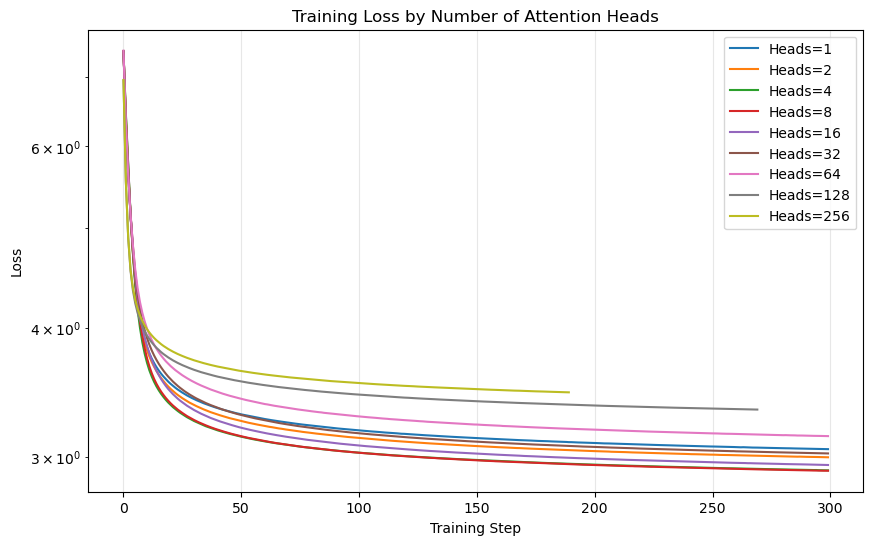

In [857]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for exp_value in sorted(train_losses['heads'].unique()):
    exp_data = train_losses[train_losses['heads'] == exp_value]
    
    # Plot the line for this experiment with a label
    plt.plot(np.arange(len(exp_data['loss_value'])), exp_data['loss_value'], label=f'Heads={exp_value}')

plt.yscale("log")
# Add labels and title
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss by Number of Attention Heads')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

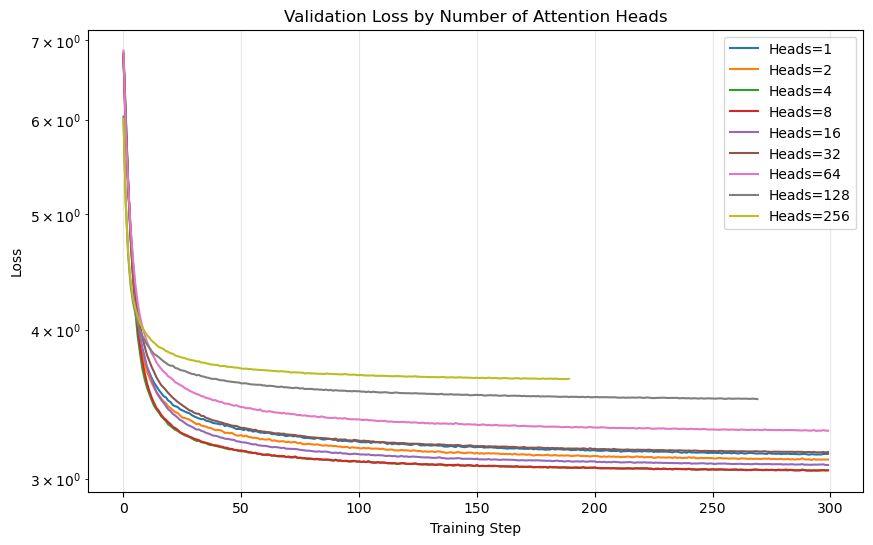

In [861]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for exp_value in sorted(val_losses['heads'].unique()):
    exp_data = val_losses[val_losses['heads'] == exp_value]
    
    # Plot the line for this experiment with a label
    plt.plot(np.arange(len(exp_data['loss_value'])), exp_data['loss_value'], label=f'Heads={exp_value}')

plt.yscale("log")
# Add labels and title
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Validation Loss by Number of Attention Heads')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

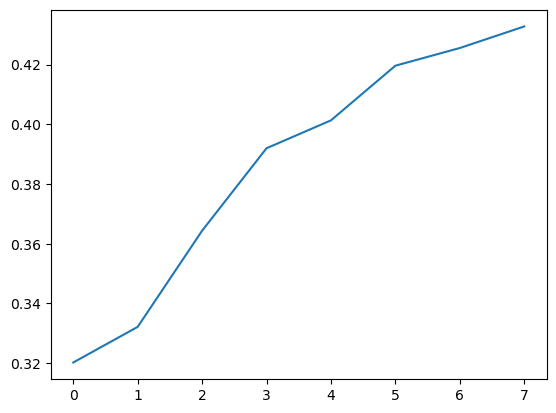

In [210]:
exp = [1, 2, 4, 8, 16, 32, 64, 128,]
bleu_all = [0.3202086407305643, 0.3321382919148217, 0.3643365421739973, 0.3919667874700643, 0.40130676686094235, 0.41961240889244555, 0.42554120063412926, 0.4327560724431759, ]
plt.plot(bleu_all)

In [201]:
## amount of samples --> BLEU scores (shuffled scores) --> 32 heads
scores_64_heads = [0.4256169182735742, 0.42690940939605493, 0.42548019113737423,  0.4259760131091309, 0.4254260345079961, 0.42506663023472047, 0.42546184434770007, 0.4253629262202892, 
                   0.4253629262202892, 0.42554120063412926]

scores_1_heads = [0.33226783962992684, 0.3318824271745313, 0.3315087861742015, 0.33214279626129856, 0.3321707536497053, 0.3317419649242165, 0.33213349105031675, 0.3322169513421279, 
                  0.33203347653978116, 0.3321382919148217]

scores_32_heads = [0.4197961845833259, 0.41985384757403565, 0.4192411665781122, 0.4192042077961702, 0.41904543283081724, 0.4190786349825114, 0.41945234656101266, 0.4191515382983203, 
   0.41900252582300457, 0.41961240889244555]

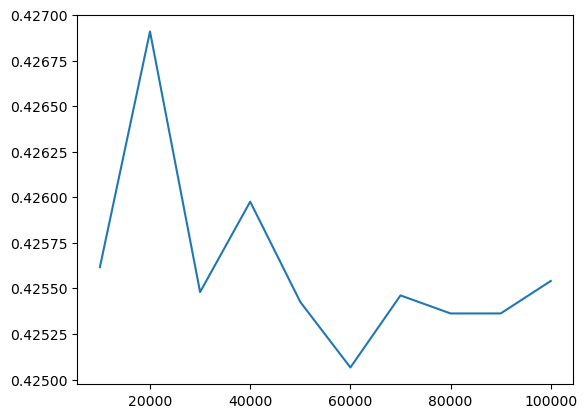

In [204]:
import numpy as np
plt.plot(np.arange(1, len(scores_64_heads) + 1) * 10000, scores_64_heads)

## Metrics Calculations

In [77]:
from metrics import corpus_bleu, sentence_bleu

In [ ]:
original_sentence_1 = "प्रचीन काल में एक राजा के राज्य में एकादशी के दिन सभी लोग व्रत रखते थे।"
model_sentence_1 = "प्राचीन काल में, सभी लोग एकादशी के दिन में, एकादशी के दिन में प्रचार करते थे।"
sentence_bleu([original_sentence_1], model_sentence_1, generate_more=True)

In [ ]:
original_sentence = 'भारत-प्रशांत क्षेत्र में समुद्री स्वतंत्रता के लिए भारत-अमेरिका के आह्वान के संदर्भ में हुआ ने कहा कि समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में उल्लेखित कानूनी अधिकारों को कायम रखेंगे और हम यह उम्मीद भी करते हैं कि नौवहन स्वतंत्रता के लिए पक्ष वास्तविक काम करें।' 
original_sentence_mod = "उन्होंने कहा कि भारत-ऑस्ट्रेलिया के बीच समुद्री सुरक्षा के संबंध में भारत और अमेरिका के बीच सहमति बनी है।"
model_sentence = 'भारत-अमेरिका के भारत-अमेरिका के लिए समुद्री स्वतंत्रता की अपील पर हुवा ने कहा, समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में दायर कानूनी अधिकारों को बनाए रखते हैं और हम उम्मीद कर सकते हैं कि पक्ष ने भी सिंचाई की स्वतंत्रता सुनिश्चित करने के लिए वास्तविक चीजें कर सकते हैं।'
a = sentence_bleu([original_sentence, original_sentence_mod], model_sentence, generate_more=False)
b = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence])

In [13]:
t1 = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence], raw_values=True)
t2 = corpus_bleu([[original_sentence_1]], [model_sentence_1], raw_values=True)

In [ ]:
corpus_bleu([[original_sentence, original_sentence_mod], [original_sentence_1]], [model_sentence, model_sentence_1])

In [ ]:
## Future Thoughts
# Build that visualiser for attention heads
# build some abalation pipeline ? 
# be able to run experiments keeping the number of total parameters constant but changing number of heads etc or should I keep
# change the variable while keeping the rest of the config params constant

## Testing Scores

In [ ]:
from collections import OrderedDict
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/hindi_model_small_full_5/Model_230", map_location=torch.device("cpu"))
checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

In [147]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file="../papers/attention_is_all_you_need/BPE/en-hi.model")
# model_prediction(model, None, config['SEQ_LEN'], device, sp.bos_id(), sp.eos_id(), sp.pad_id())

In [11]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings_app = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings_app = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings_app, tgt_encodings_app, output_encodings))
        # full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
            src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
            # print(src_seq)
            
            # Convert to tensors
            src_tensor = torch.tensor(src_seq, dtype=torch.long)
            tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
            output_tensor = torch.tensor(output_seq, dtype=torch.long)

            # **Ensure the sequence length does not exceed `seq_len`**
            if src_tensor.size(0) > self.seq_len:
                src_tensor = src_tensor[:self.seq_len]  # Crop excess tokens
            if tgt_tensor.size(0) > self.seq_len:
                tgt_tensor = tgt_tensor[:self.seq_len]  # Crop excess tokens
            if output_tensor.size(0) > self.seq_len:
                output_tensor = output_tensor[:self.seq_len]  # Crop excess tokens

            # **Pad sequences to `seq_len` if they are shorter**
            src_tensor = F.pad(src_tensor, (0, max(0, self.seq_len - src_tensor.size(0))), value=self.pad_token)
            tgt_tensor = F.pad(tgt_tensor, (0, max(0, self.seq_len - tgt_tensor.size(0))), value=self.pad_token)
            output_tensor = F.pad(output_tensor, (0, max(0, self.seq_len - output_tensor.size(0))), value=self.pad_token)
            encoder_mask = (src_tensor != self.pad_token).int()
            subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
            padding_mask = (tgt_tensor != self.pad_token).int()
            decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)



            return {
                "src": src_tensor, # Seq_len
                "tgt": tgt_tensor, # seq_len
                "output": output_tensor, # seq_len
                "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
                "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
            }
    def __len__(self): 
            return len(self.paired_encodings)
        

In [149]:
import itertools
def get_data(datapath, ref_datapath, skiprows, amount, sp):
    english_sentences = pd.read_table(Path(datapath) /  "english_small.txt",  header=None, skiprows=skiprows, nrows=amount)
    hindi_sentences = pd.read_table(Path(datapath) /  "hindi_small.txt",  header=None, skiprows=skiprows, nrows=amount)

    english_encoded = sp.encode_as_ids(english_sentences.iloc[:, 0].to_list())
    with open(ref_datapath / "test.json", 'r') as f:
        ref_sentences = json.load(f)
    ref_sentences = ref_sentences[ : amount]
    encoding_hindi = list(itertools.chain.from_iterable(ref_sentences))
    # assert len(english_encoded) == len(ref_sentences)
    hindi_encoded = sp.encode_as_ids(encoding_hindi)[:amount]
    return english_encoded, hindi_encoded, ref_sentences, hindi_sentences

In [150]:
def get_dataloaders(sp, english_encoded, tgt_encoded, amount):
    full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=tgt_encoded, sos_token=sp.bos_id(), eos_token=sp.eos_id(),
                                        pad_token=sp.pad_id())
    dataloader = DataLoader(full_data, batch_size=amount, pin_memory=True, shuffle=False)
    return full_data, dataloader

In [151]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    underlying_model = model.module if hasattr(model, 'module') else model

    encoder_input = batch['src'].to(device)  # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device)  # B x 1 x 1 x seq_len
    encoder_output = underlying_model.encode(encoder_input, encoder_mask)

    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[:, 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device)
        other_mask = (decoder_input != pad_token).int().unsqueeze(1)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
        out = underlying_model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
        next_tokens = torch.where(finished, pad_token, next_tokens)
        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)
        if finished.all():
            break

    return decoder_input

In [152]:
import json
english_encoded, hindi_encoded, ref_sentences, hindi_sentences = get_data(Path("../data/en-hi/"), Path("../data/en-hi/"), skiprows=550_000, amount=256, sp=sp)

In [153]:
test, dataloader = get_dataloaders(sp, english_encoded, hindi_encoded, 32)

## Attention Visualiser


In [ ]:
from collections import OrderedDict
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/hindi_model_4_256_2048_2_2/Model_300", map_location=torch.device("cpu"))
checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

In [12]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file="../papers/attention_is_all_you_need/BPE/en-hi.model")

def get_padded_sentence(english_sentence, sp, seq_len = 140):
    english_encoded = sp.Encode(english_sentence)    
    src_encodings = [sp.bos_id()] + english_encoded + [sp.eos_id()]
    tgt_encodings = [sp.pad_id()] * seq_len
    src_tensor = torch.tensor(src_encodings, dtype=torch.long)
    tgt_tensor = torch.tensor(tgt_encodings, dtype=torch.long)

    if src_tensor.size(0) > seq_len:
        src_tensor = src_tensor[:seq_len]  # Crop excess tokens
    if tgt_tensor.size(0) > seq_len:
        tgt_tensor = tgt_tensor[:seq_len]  # Crop excess tokens

    src_tensor = F.pad(src_tensor, (0, max(0, seq_len - src_tensor.size(0))), value=sp.pad_id())
    encoder_mask = (src_tensor != sp.pad_id()).int()
    subsequent_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.int))
    padding_mask = (tgt_tensor != sp.pad_id()).int()
    decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

    return {
        "src": src_tensor.unsqueeze(0), # Seq_len
        "tgt": tgt_tensor.unsqueeze(0), # seq_len
        "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0).unsqueeze(0), # 1 x 1 x 1 x seq_len
        "decoder_mask" : decoder_mask.unsqueeze(0).unsqueeze(0), # 1 x  1 x seq_len x seq_len
    }

In [13]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token, method='greedy', k=3, V=100, alpha=0.6):
    underlying_model = model.module if hasattr(model, 'module') else model
    if method == 'greedy':
        encoder_input = batch['src'].to(device)  # B x seq_len
        encoder_masks = batch['encoder_masks'] #.to(device)  # B x 1 x 1 x seq_len
        decoder_encoder_masks = batch['decoder_encoder_masks'] #.to(device)
        encoder_output = underlying_model.encode(encoder_input, encoder_masks)
        B = encoder_input.size(0)
        decoder_input = torch.full((B, max_len), pad_token).to(device)
        decoder_input[:, 0] = sos_token
        finished = torch.zeros(B, dtype=torch.bool, device=device)
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device)

        for t in range(max_len - 1):
            other_mask = (decoder_input != pad_token).int().unsqueeze(1)
            decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
            if type(decoder_encoder_masks) == list:
                out = underlying_model.decode(decoder_input, encoder_output, encoder_mask=decoder_encoder_masks, decoder_mask=decoder_mask)
            else:
                out = underlying_model.decode(decoder_input, encoder_output, encoder_mask=encoder_masks, decoder_mask=decoder_mask)
                
            prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
            next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
            next_tokens = torch.where(finished, pad_token, next_tokens)
            decoder_input[:, t + 1] = next_tokens
            finished |= (next_tokens == eos_token)
            if finished.all():
                break
        return decoder_input
    
    elif method == 'beam_search':
        encoder_input = batch['src'].to(device)  # 1 x seq_len
        encoder_mask = batch['encoder_mask'].to(device)  # 1 x 1 x 1 x seq_len
        encoder_output = underlying_model.encode(encoder_input, encoder_mask)
        decoder_input = torch.full((k, max_len), pad_token, dtype=torch.long, device=device)
        decoder_input[:, 0] = sos_token
        
        scores = torch.zeros(k, device=device)
        finished = torch.zeros(k, dtype=torch.bool, device=device)
        
        completed_sequences = []
        completed_scores = []
        
        subsequent_mask = torch.tril(
            torch.ones((max_len, max_len), device=device, dtype=torch.uint8)
        ).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, max_len, max_len)
        
        beam_encoder_output = encoder_output.expand(k, -1, -1)
        beam_src_mask = encoder_mask.expand(k, -1, -1, -1)
        
        for t in range(max_len - 1):
            if finished.all():
                break
                
            pad_mask = (decoder_input != pad_token).unsqueeze(1).unsqueeze(1)
            decoder_mask = subsequent_mask & pad_mask
            out = model.decode(decoder_input, beam_encoder_output, beam_src_mask, decoder_mask)
            logits = model.proj(out)  # shape: (beam_size, max_len, vocab_size)
            log_probs = F.log_softmax(logits[:, t, :], dim=-1)  # shape: (beam_size, vocab_size)
            all_candidates = []
            for beam_idx in range(k):
                if finished[beam_idx]:
                    continue
                    
                top_v_logprobs, top_v_indices = log_probs[beam_idx, :].topk(V)
                for v_idx in range(V):
                    token = top_v_indices[v_idx].item()
                    logprob = top_v_logprobs[v_idx].item()
                    new_score = scores[beam_idx] + logprob
                    
                    # Current length is t+1 (+1 for the token we're adding)
                    seq_len = t + 2  # +1 for current position, +1 for 0-indexing
                    normalised_score = new_score / (seq_len ** alpha)
                    all_candidates.append((beam_idx, token, normalised_score, new_score))
            
            if not all_candidates:
                break
            all_candidates.sort(key=lambda x: x[2], reverse=True)
            
            next_decoder_input = torch.full((k, max_len), pad_token, dtype=torch.long, device=device)
            next_scores = torch.zeros(k, device=device)
            next_finished = torch.zeros(k, dtype=torch.bool, device=device)
            
            for new_idx, (old_beam_idx, token, _, raw_score) in enumerate(all_candidates[:k]):
                next_decoder_input[new_idx] = decoder_input[old_beam_idx].clone()
                next_decoder_input[new_idx, t+1] = token
                next_scores[new_idx] = raw_score
                if token == eos_token:
                    next_finished[new_idx] = True
                    
                    completed_sequences.append(next_decoder_input[new_idx].clone())
                    completed_scores.append(raw_score / ((t+2) ** alpha)) 
                elif next_finished[new_idx]:
                    completed_sequences.append(next_decoder_input[new_idx].clone())
                    completed_scores.append(raw_score / ((t+2) ** alpha))
            
            decoder_input = next_decoder_input
            scores = next_scores
            finished = next_finished
        
        for beam_idx in range(k):
            if not finished[beam_idx]:
                completed_sequences.append(decoder_input[beam_idx].clone())
                completed_scores.append(scores[beam_idx] / (max_len ** alpha))
        
        if completed_sequences:
            best_idx = torch.tensor(completed_scores, device=device).argmax().item()
            return completed_sequences[best_idx].unsqueeze(0)
        else:
            # If no completed sequences (shouldn't happen), return best from current beam
            best_idx = scores.argmax().item()
            return decoder_input[best_idx].unsqueeze(0)  # Add batch dimension


In [14]:
import torch
import numpy as np

class AttentionScoreHook:
    def __init__(self, model):
        self.model = model
        self.attention_scores = []
        self.queries = []
        self.keys = []
        self.hook_handles = []
        self.layer_count = 0
        self._register_hooks()
        
    def _make_hook(self, layer_idx):
        def hook(module, input, output):
            if hasattr(module, 'attention_scores'):
                self.attention_scores.append((layer_idx, module.attention_scores.detach().cpu().clone()))
                self.queries.append((layer_idx, module.queries.detach().cpu().clone()))
                self.keys.append((layer_idx, module.keys.detach().cpu().clone()))
        return hook
    
    def _register_hooks(self):
        """Register hooks on all MultiHeadAttention modules"""
        layer_idx = 0
        for encoder_layer in self.model.encoder.layers:
            handle = encoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
        for decoder_layer in self.model.decoder.layers:
            # Self-attention
            handle = decoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
            # Cross-attention
            handle = decoder_layer.attention_2.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
    
    def get_attention_scores(self):
        """
        Get attention scores as [batch_size, num_layers, num_heads, seq_len, seq_len]
        
        Returns:
            Tuple of (attention_scores, queries, keys) each with shape 
            [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_scores
            and appropriate shapes for queries and keys
        """
        sorted_scores = sorted(self.attention_scores, key=lambda x: x[0])
        sorted_queries = sorted(self.queries, key=lambda x: x[0])
        sorted_keys = sorted(self.keys, key=lambda x: x[0])
        
        results = []
        for sorted_tensor in [sorted_scores, sorted_queries, sorted_keys]:
            tensors = [tensor for _, tensor in sorted_tensor]
            
            # Stack along a new dimension (layer dimension)
            stacked = torch.stack(tensors, dim=0)  # [num_layers, batch, heads, seq_len, seq_len/dk/dk]
            
            # Transpose to get [batch_size, num_layers, num_heads, seq_len, seq_len/dk/dk]
            transposed = stacked.permute(1, 0, 2, 3, 4)
            result = transposed.numpy()
            results.append(result)
        
        self.attention_scores = []
        self.keys = []
        self.queries = []
        
        return results[0], results[1], results[2]
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

def extract_attention_weights(model, src, tgt, src_masks=None, tgt_masks=None, src_tgt_masks=None):
    """
    Extract attention weights from the model.
    
    Returns:
        Tuple of (attention_weights, queries, keys) each with shape 
        [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_weights
    """
    hook = AttentionScoreHook(model)    
    with torch.inference_mode():
        model(src, tgt, src_masks, tgt_masks, src_tgt_masks, return_attention=True)
    
    attention_weights, queries, keys = hook.get_attention_scores()
    hook.remove_hooks()
    
    return attention_weights, queries, keys

In [15]:
def reorder_attention_values(attention_values, n_encoders):
    return {
        'encoder_attention' : attention_values[:n_encoders, ...],
        'decoder_self_attention' : attention_values[n_encoders::2, ...],
        'decoder_cross_attention' : attention_values[n_encoders + 1::2, ...]
    }

In [16]:
def get_token_until_eos(tokens):
    if '<EOS>' in tokens:
        eos_idx = tokens.index('<EOS>')
        return tokens[: eos_idx + 1]
    else:
        return tokens

In [129]:
model.eval()
converted_sentence = get_padded_sentence("He must have gone in that room.", sp)
pred = model_prediction(model, converted_sentence, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())
# beam_search_best = model_prediction(model, converted_sentence, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id(), method='beam_search', k=3, V = 500)
split_encoded = sp.id_to_piece(converted_sentence['src'][0].tolist())
split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
padding_mask = (pred != sp.pad_id()).int()
decoder_mask = subsequent_mask & padding_mask
attention_vals, query_vals, keys_vals = extract_attention_weights(model, converted_sentence['src'], pred, converted_sentence['encoder_mask'], decoder_mask.unsqueeze(0))
# organised_weights = reorder_attention_values(attention_vals, 2)
split_encoded_trim = get_token_until_eos(split_encoded)
split_decoded_trim = get_token_until_eos(split_decoded)

In [ ]:
sp.Decode(pred.detach().cpu().tolist()[0])

In [ ]:
run_attention_dashboard(attention_vals, split_encoded_trim, split_decoded_trim, colormap='Viridis')

In [ ]:
run_model_dashboard(attention_vals, split_encoded_trim, split_decoded_trim)

In [ ]:
from attention_visualisation import run_neuron_dashboard
raw_attention = query_vals @ keys_vals.transpose(0, 1, 3, 2)
run_neuron_dashboard(raw_attention, attention_vals, query_vals, keys_vals, split_encoded_trim,  split_decoded_trim)

## Ablation Studies

### Why not simple correlation

In [17]:
english_sentences = [
 "Not until the government intervened did the companies agree to change their policies regarding environmental protection.",
    "Had the circumstances been different, I might have considered his proposal more seriously.",
    "Rarely have I encountered such an eloquent speaker who could captivate an audience so effortlessly.",
    "We will go to the park tomorrow.",
    "She has been learning Hindi for two years.",
    "The children are playing in the garden.",
    "Could you please pass me that cup of tea?",
    "I would have come to your party if I had known about it earlier.",
    "After finishing his homework, he decided to take a short break.",
    "The movie we watched last night was both entertaining and educational.",
    "Despite the rain, they continued their journey through the mountains.",
    "She asked me whether I would prefer coffee or tea with breakfast.",
    "Diwali is one of the most important festivals celebrated in India.",
    "Cricket is extremely popular in both India and England.",
    "The Taj Mahal is a beautiful monument located in Agra, India.",
    "Indian cuisine is known for its variety of spices and flavors.",
    "During the monsoon season, many parts of India receive heavy rainfall.",
    "Had I known about the traffic, I would have left home much earlier.",
    "The company, which was founded ten years ago, has grown substantially since then.",
    "By the time we arrived at the station, the train had already departed.",
    "Not only did she complete the project on time, but she also exceeded expectations.",
    "Although it was raining heavily, we decided to go for a walk anyway.",
    "The intricate relationship between language and culture is something that translators must navigate carefully.",
    "In spite of having studied the subject for many years, he found himself struggling with the complex theories presented in the lecture.",
    "The rapid advancement of technology has transformed how we communicate, work, and even think about the world around us.",
    "After careful consideration of all the evidence presented during the trial, the jury reached a unanimous verdict of not guilty.",
    "The economic implications of climate change, while difficult to quantify precisely, are likely to be far-reaching and potentially devastating for certain regions.",
        "The cat sat on the mat.",
    "He runs every morning before sunrise.",
    "Water boils at 100 degrees Celsius at sea level.",
    "My brother bought a new car yesterday.",
    "They celebrated their anniversary at an expensive restaurant.",
    "Can you help me with this math problem?",
    "The museum closes at 5 PM on weekdays.",
    "I've never been to Australia before.",
    "She speaks three languages fluently.",
    "The book was so interesting that I couldn't put it down.",
    "Having finished all his assignments, Tom decided to watch a movie.",
    "The ancient temple, which was discovered by archaeologists last year, dates back to the 12th century.",
    "Despite having all the necessary qualifications, she wasn't selected for the position.",
    "Not only did he solve the problem, but he also explained the solution clearly to everyone.",
    "Had they arrived on time, they wouldn't have missed the opening ceremony.",
    "The professor whose lecture I attended yesterday is a renowned expert in quantum physics.",
    "Seldom have I seen such a magnificent sunset over the ocean.",
    "By the time we reach the summit, the sun will have already set.",
    "The company's decision to expand into new markets has proven to be highly profitable.",
    "Although I had prepared thoroughly for the interview, I still felt nervous when I walked into the room.",
    "The complexity of the human brain, with its billions of neural connections, continues to fascinate scientists worldwide.",
    "She wondered whether accepting the job offer would require her to relocate to another city.",
    "The documentary about marine life that we watched last weekend was both informative and visually stunning.",
    "Having lived in the village for over fifty years, the old man knew every path and shortcut through the forest.",
    "The new policy, which aims to reduce carbon emissions, will be implemented gradually over the next five years.",
    "The child's drawing, though simple in execution, conveyed a depth of emotion that surprised everyone.",
    "Whenever it rains heavily, the basement of our old house gets flooded.",
    "The recipe calls for two tablespoons of olive oil.",
    "My grandmother taught me how to knit when I was eight years old.",
    "The train to Manchester leaves every hour from platform 3.",
    "This song reminds me of my childhood.",
    "Could you please turn down the volume? I'm trying to study.",
    "We should arrive at the airport at least two hours before our flight.",
    "The exhibition featuring works by local artists will run until the end of the month.",
    "I'd rather stay home and read a book than go to the party.",
    "The mysterious disappearance of the artifacts from the museum remains unsolved to this day.",
    "Many scientific discoveries throughout history have occurred accidentally during experiments designed for entirely different purposes.",
    "The intricate pattern on the ancient vase suggests a level of craftsmanship far beyond what was previously thought possible for that time period.",
    "While some economists argue for increased government spending during recessions, others advocate for fiscal restraint and balanced budgets.",
    "The philosopher whose ideas revolutionized Western thought spent most of his life in relative obscurity, only gaining recognition after his death.",
    "Should the weather improve, we might consider having the reception in the garden rather than indoors.",
    "The software update, which was released last week, includes several new features and security improvements.",
    "I've been meaning to tell you about my decision to change careers.",
    "They're planning to renovate their kitchen next month.",
    "The dog barked loudly when a stranger approached the house.",
    "We've been waiting for over an hour, but the bus still hasn't arrived.",
    "How many languages can you speak fluently?",
    "The mountain climbers reached the summit just before noon.",
    "She always drinks a cup of green tea before going to bed.",
    "The old bridge, which has stood for over a century, will finally be replaced next year.",
    "Notwithstanding the difficulties encountered during the project, the team managed to complete it on schedule.",
    "The theory that the universe is constantly expanding has gained widespread acceptance among astronomers and physicists.",
    "To what extent does social media influence political opinions and voting behavior in modern democracies?",
    "The defendant, having maintained his innocence throughout the trial, was visibly relieved when the verdict was announced.",
    "The symphony, composed during the darkest period of the musician's life, paradoxically conveys a sense of hope and resilience.",
    "Scarcely had we left the house when it started to rain heavily.",
    "The implications of artificial intelligence for the future of work remain hotly debated among economists and technology experts.",
    "The committee, after deliberating for several hours, finally reached a consensus on the proposed amendments.",
    "The painting, which had been thought lost for decades, was discovered in the attic of an old country house.",
    "Without adequate preparation, even the most talented athletes are unlikely to perform at their best during competitions.",
    "The novel's protagonist, despite facing numerous setbacks and challenges, never abandons her fundamental principles and values.",
    "The architectural design of the new cultural center incorporates elements from various historical periods while maintaining a cohesive aesthetic.",
    "Economists have long debated the relative merits of free markets versus government intervention in addressing income inequality.",
    "The manuscript, written in a previously unknown script, has puzzled linguists and historians for more than a century.",
    "She walks to work every day to stay fit.",
    "I forgot my umbrella, so I got wet in the rain.",
    "They built a sandcastle on the beach.",
    "My favorite color is blue.",
    "The clock on the wall stopped working last week.",
    "We planted tomatoes and peppers in our garden this year.",
    "The children laughed when the clown appeared at the birthday party.",
    "He always forgets where he puts his keys.",
    "India beat Australia by 10 wickets in the world cup finals putting up a dominating performance."
]

In [18]:
hindi_translations = [
    [
        "सरकार के हस्तक्षेप के बाद ही कंपनियां पर्यावरण संरक्षण के संबंध में अपनी नीतियों को बदलने के लिए सहमत हुईं।",
        "जब तक सरकार ने हस्तक्षेप नहीं किया, तब तक कंपनियां पर्यावरण संरक्षण से संबंधित अपनी नीतियों को बदलने के लिए राज़ी नहीं हुईं।"
    ],
    [
        "यदि परिस्थितियां अलग होतीं, तो मैं उसके प्रस्ताव पर अधिक गंभीरता से विचार करता।",
        "अगर हालात भिन्न होते, तो मैं उनके प्रस्ताव को और अधिक गंभीरता से समझता।"
    ],
    [
        "शायद ही मैंने कभी ऐसे वक्ता का सामना किया हो जो इतनी सहजता से दर्शकों को मंत्रमुग्ध कर सके।",
        "बहुत कम ही मुझे ऐसे वाक्पटु वक्ता मिले हैं जो बिना किसी प्रयास के श्रोताओं को अपनी ओर आकर्षित कर सकें।"
    ],
    [
        "हम कल पार्क जाएंगे।",
        "कल हम उद्यान में जाएँगे।"
    ],
    [
        "वह दो साल से हिंदी सीख रही है।",
        "उसे हिंदी सीखते हुए दो वर्ष हो गए हैं।"
    ],
    [
        "बच्चे बगीचे में खेल रहे हैं।",
        "बच्चे बाग में खेल कर रहे हैं।"
    ],
    # 7
    [
        "क्या आप मुझे वह चाय का कप पास कर सकते हैं?",
        "क्या आप कृपया मुझे वह चाय का प्याला दे सकते हैं?"
    ],
    # 8
    [
        "अगर मुझे पहले पता होता, तो मैं आपकी पार्टी में आता।",
        "यदि मुझे पहले से जानकारी होती, तो मैं आपकी दावत में अवश्य आता।"
    ],
    # 9
    [
        "अपना होमवर्क खत्म करने के बाद, उसने थोड़ा आराम करने का फैसला किया।",
        "अपना गृहकार्य पूरा करने के पश्चात, उसने एक छोटा विश्राम लेने का निर्णय लिया।"
    ],
    # 10
    [
        "कल रात हमने जो फिल्म देखी थी वह मनोरंजक और शिक्षाप्रद दोनों थी।",
        "हमने बीती रात जिस चलचित्र को देखा था वह मनोरंजन के साथ-साथ शिक्षाप्रद भी था।"
    ],
    # 11
    [
        "बारिश के बावजूद, उन्होंने पहाड़ों के माध्यम से अपनी यात्रा जारी रखी।",
        "वर्षा होने के बावजूद भी, वे पर्वतों से होकर अपनी यात्रा पर बने रहे।"
    ],
    # 12
    [
        "उसने मुझसे पूछा कि क्या मैं नाश्ते के साथ कॉफी या चाय पसंद करूंगा।",
        "उसने मुझसे जानना चाहा कि मैं प्रातःकालीन भोजन के साथ कॉफी पीना पसंद करूंगा या चाय।"
    ],
    # 13
    [
        "दिवाली भारत में मनाए जाने वाले सबसे महत्वपूर्ण त्योहारों में से एक है।",
        "दीपावली भारतवर्ष में मनाए जाने वाले प्रमुख पर्वों में से एक है।"
    ],
    # 14
    [
        "क्रिकेट भारत और इंग्लैंड दोनों में अत्यधिक लोकप्रिय है।",
        "क्रिकेट भारत और इंग्लैंड दोनों देशों में बेहद प्रसिद्ध खेल है।"
    ],
    # 15
    [
        "ताजमहल आगरा, भारत में स्थित एक सुंदर स्मारक है।",
        "ताज महल एक खूबसूरत स्मारक है जो आगरा, भारत में स्थित है।"
    ],
    # 16
    [
        "भारतीय व्यंजन अपने विविध मसालों और स्वादों के लिए जाने जाते हैं।",
        "भारतीय खानपान विभिन्न प्रकार के मसालों और स्वादों के लिए प्रसिद्ध है।"
    ],
    # 17
    [
        "मानसून के मौसम के दौरान, भारत के कई हिस्सों में भारी वर्षा होती है।",
        "बरसात के मौसम में, भारत के अनेक क्षेत्रों में मूसलाधार बारिश होती है।"
    ],
    # 18
    [
        "अगर मुझे ट्रैफिक के बारे में पता होता, तो मैं घर से बहुत पहले निकल जाता।",
        "यदि मुझे यातायात की भीड़ का अंदाजा होता, तो मैं घर से काफी पहले ही निकल गया होता।"
    ],
    # 19
    [
        "कंपनी, जिसकी स्थापना दस साल पहले हुई थी, तब से काफी बढ़ गई है।",
        "वह कंपनी, जिसकी नींव दस वर्ष पूर्व रखी गई थी, तब से लेकर अब तक काफी विकसित हो चुकी है।"
    ],
    # 20
    [
        "जब तक हम स्टेशन पहुंचे, तब तक ट्रेन पहले ही जा चुकी थी।",
        "हमारे स्टेशन पहुँचने से पहले ही गाड़ी चली गई थी।"
    ],
    # 21
    [
        "न केवल उसने परियोजना को समय पर पूरा किया, बल्कि उसने उम्मीदों से भी अधिक काम किया।",
        "उसने न सिर्फ प्रोजेक्ट समय पर पूरा किया, बल्कि अपेक्षाओं से भी बढ़कर प्रदर्शन किया।"
    ],
    # 22
    [
        "हालांकि तेज बारिश हो रही थी, हमने फिर भी टहलने जाने का फैसला किया।",
        "भले ही मूसलाधार बारिश हो रही थी, फिर भी हमने घूमने जाने का निर्णय लिया।"
    ],
    # 23
    [
        "भाषा और संस्कृति के बीच जटिल संबंध ऐसा कुछ है जिसे अनुवादकों को सावधानी से संभालना चाहिए।",
        "भाषा और संस्कृति के बीच की पेचीदा अंतर्संबंधिता ऐसी चीज है जिससे अनुवादकों को सावधानीपूर्वक निपटना चाहिए।"
    ],
    # 24
    [
        "कई वर्षों तक विषय का अध्ययन करने के बावजूद, उसने खुद को व्याख्यान में प्रस्तुत जटिल सिद्धांतों से जूझते हुए पाया।",
        "वर्षों तक विषय का अध्ययन करने के उपरांत भी, वह व्याख्यान में प्रस्तुत किए गए जटिल सिद्धांतों को समझने में कठिनाई महसूस कर रहा था।"
    ],
    # 25
    [
        "प्रौद्योगिकी का तेजी से विकास ने बदल दिया है कि हम कैसे संवाद करते हैं, काम करते हैं, और यहां तक कि हमारे आसपास की दुनिया के बारे में सोचते हैं।",
        "तकनीकी का द्रुत विकास ने हमारे संचार, कार्य और यहां तक कि हमारे आसपास की दुनिया के बारे में हमारी सोच को भी परिवर्तित कर दिया है।"
    ],
    # 26
    [
        "मुकदमे के दौरान प्रस्तुत सभी सबूतों पर सावधानीपूर्वक विचार करने के बाद, जूरी ने सर्वसम्मति से निर्दोष का फैसला सुनाया।",
        "परीक्षण के दौरान प्रस्तुत किए गए समस्त साक्ष्यों पर ध्यानपूर्वक विचार करने के पश्चात, न्यायाधीश मंडल निर्दोष का सर्वसम्मत निर्णय पर पहुंचा।"
    ],
    # 27
    [
        "जलवायु परिवर्तन के आर्थिक प्रभाव, हालांकि सटीक रूप से मात्रा निर्धारित करना मुश्किल है, व्यापक होने की संभावना है और कुछ क्षेत्रों के लिए संभावित रूप से विनाशकारी हो सकते हैं।",
        "जलवायु परिवर्तन के आर्थिक निहितार्थ, यद्यपि उनका सटीक मूल्यांकन करना कठिन है, दूरगामी हो सकते हैं और कुछ क्षेत्रों के लिए संभावित रूप से विनाशकारी साबित हो सकते हैं।"
    ],
    # 28
    [
        "बिल्ली चटाई पर बैठी थी।",
        "बिल्ली दरी पर बैठी हुई थी।"
    ],
    # 29
    [
        "वह हर सुबह सूर्योदय से पहले दौड़ता है।",
        "वह प्रतिदिन सूरज निकलने से पूर्व दौड़ लगाता है।"
    ],
    # 30
    [
        "समुद्र तल पर पानी 100 डिग्री सेल्सियस पर उबलता है।",
        "समुद्र तल पर जल 100 डिग्री सेल्सियस तापमान पर उबलता है।"
    ],
    # 31
    [
        "मेरे भाई ने कल एक नई कार खरीदी।",
        "मेरे भ्राता ने बीते कल एक नई गाड़ी क्रय की।"
    ],
    # 32
    [
        "उन्होंने अपनी सालगिरह एक महंगे रेस्तरां में मनाई।",
        "उन्होंने अपनी वर्षगांठ एक विलासी भोजनालय में मनाई।"
    ],
    # 33
    [
        "क्या आप मुझे इस गणित की समस्या में मदद कर सकते हैं?",
        "क्या आप मुझे इस अंकगणित के सवाल को हल करने में सहायता कर सकते हैं?"
    ],
    # 34
    [
        "संग्रहालय सप्ताह के दिनों में शाम 5 बजे बंद होता है।",
        "अजायबघर कार्य दिवसों पर सायं 5 बजे बंद हो जाता है।"
    ],
    # 35
    [
        "मैं पहले कभी ऑस्ट्रेलिया नहीं गया हूं।",
        "मैंने पहले कभी भी ऑस्ट्रेलिया की यात्रा नहीं की है।"
    ],
    # 36
    [
        "वह तीन भाषाएं धाराप्रवाह बोलती है।",
        "वह तीन भाषाओं पर पूर्ण अधिकार रखती है।"
    ],
    # 37
    [
        "किताब इतनी दिलचस्प थी कि मैं इसे छोड़ नहीं सका।",
        "पुस्तक इतनी रोचक थी कि मैं उसे बीच में छोड़ने में असमर्थ था।"
    ],
    # 38
    [
        "अपने सभी कार्य पूरे करने के बाद, टॉम ने एक फिल्म देखने का फैसला किया।",
        "सारे असाइनमेंट समाप्त करने के उपरांत, टॉम ने एक चलचित्र देखने का निर्णय लिया।"
    ],
    # 39
    [
        "प्राचीन मंदिर, जिसे पिछले साल पुरातत्वविदों द्वारा खोजा गया था, 12वीं शताब्दी का है।",
        "वह प्राचीन मंदिर, जो पिछले वर्ष पुरातत्वविदों ने खोजा था, 12वीं सदी से संबंधित है।"
    ],
    # 40
    [
        "सभी आवश्यक योग्यताएं होने के बावजूद, उसे पद के लिए चयनित नहीं किया गया।",
        "समस्त आवश्यक अर्हताओं के होते हुए भी, उसका चयन उस पद के लिए नहीं हुआ।"
    ],
    # 41
    [
        "न केवल उसने समस्या का समाधान किया, बल्कि उसने सभी को स्पष्ट रूप से समाधान भी समझाया।",
        "उसने न सिर्फ समस्या हल की, बल्कि सभी के समक्ष उसका हल स्पष्टता से प्रस्तुत भी किया।"
    ],
    # 42
    [
        "अगर वे समय पर पहुंचे होते, तो उन्होंने उद्घाटन समारोह नहीं छोड़ा होता।",
        "यदि वे निर्धारित समय पर आ गए होते, तो उन्हें उद्घाटन समारोह से वंचित नहीं होना पड़ता।"
    ],
    # 43
    [
        "प्रोफेसर जिनका व्याख्यान मैंने कल सुना था, क्वांटम भौतिकी के प्रसिद्ध विशेषज्ञ हैं।",
        "जिन प्राध्यापक का व्याख्यान मैंने गतदिन सुना था, वे क्वांटम भौतिकी के विख्यात विशेषज्ञ हैं।"
    ],
    # 44
    [
        "शायद ही मैंने समुद्र पर ऐसा शानदार सूर्यास्त देखा हो।",
        "बहुत कम ही अवसर आए हैं जब मैंने समुद्र के ऊपर इतना भव्य सूर्यास्त निहारा हो।"
    ],
    # 45
    [
        "जब तक हम शिखर तक पहुंचेंगे, तब तक सूरज पहले ही डूब चुका होगा।",
        "हमारे चोटी पर पहुंचने से पहले ही सूर्य अस्त हो चुका होगा।"
    ],
    # 46
    [
        "नए बाजारों में विस्तार करने का कंपनी का निर्णय अत्यधिक लाभदायक साबित हुआ है।",
        "कंपनी द्वारा नए बाज़ारों में प्रवेश करने का फैसला बेहद फायदेमंद सिद्ध हुआ है।"
    ],
    # 47
    [
        "हालांकि मैंने साक्षात्कार के लिए अच्छी तरह से तैयारी की थी, फिर भी जब मैं कमरे में गया तो मुझे घबराहट महसूस हुई।",
        "यद्यपि मैंने इंटरव्यू के लिए पूरी तैयारी कर रखी थी, फिर भी जब मैं कक्ष में प्रवेश किया तो मुझे नर्वसनेस महसूस हुई।"
    ],
    # 48
    [
        "मानव मस्तिष्क की जटिलता, अपने अरबों तंत्रिका कनेक्शन के साथ, दुनिया भर के वैज्ञानिकों को आकर्षित करती रहती है।",
        "मानव मस्तिष्क की जटिलता, जिसमें अरबों तंत्रिका संबंध हैं, दुनिया भर के वैज्ञानिकों को अभी भी मोहित करती है।"
    ],
    # 49
    [
        "उसने सोचा कि क्या नौकरी का प्रस्ताव स्वीकार करने के लिए उसे किसी अन्य शहर में स्थानांतरित होना पड़ेगा।",
        "वह यह जानने के लिए उत्सुक थी कि क्या जॉब ऑफर स्वीकार करने से उसे दूसरे शहर में जाना पड़ेगा।"
    ],
    # 50
    [
        "समुद्री जीवन के बारे में वृत्तचित्र जिसे हमने पिछले सप्ताहांत देखा था, जानकारीपूर्ण और दृश्य रूप से आकर्षक दोनों था।",
        "पिछले सप्ताहांत हमने समुद्री जीवन पर जो डॉक्यूमेंट्री देखी थी, वह सूचनात्मक के साथ-साथ दृश्यात्मक रूप से मनमोहक भी थी।"
    ],
    # 51
    [
        "गांव में पचास से अधिक वर्षों तक रहने के बाद, बूढ़े आदमी को जंगल के हर रास्ते और शॉर्टकट का पता था।",
        "ग्राम में पचास वर्षों से अधिक समय तक निवास करने के कारण, वृद्ध व्यक्ति वन के प्रत्येक मार्ग और संक्षिप्त मार्ग से परिचित था।"
    ],
    # 52
    [
        "नई नीति, जिसका उद्देश्य कार्बन उत्सर्जन को कम करना है, अगले पांच वर्षों में धीरे-धीरे लागू की जाएगी।",
        "नवीन नीति, जिसका लक्ष्य कार्बन उत्सर्जन में कमी लाना है, आगामी पाँच वर्षों में क्रमिक रूप से क्रियान्वित की जाएगी।"
    ],
    # 53
    [
        "बच्चे का चित्र, हालांकि निष्पादन में सरल था, लेकिन उसमें भावनाओं की एक गहराई थी जिसने सभी को आश्चर्यचकित कर दिया।",
        "बालक के चित्र ने, यद्यपि सादगी से बनाया गया था, एक ऐसी भावनात्मक गहराई प्रस्तुत की जिसने सबको चकित कर दिया।"
    ],
    # 54
    [
        "जब भी तेज बारिश होती है, हमारे पुराने घर का तहखाना भर जाता है।",
        "जब-जब मूसलाधार वर्षा होती है, तब-तब हमारे पुराने घर का बेसमेंट जलमग्न हो जाता है।"
    ],
    # 55
    [
        "रेसिपी में दो बड़े चमच जैतून के तेल की आवश्यकता होती है।",
        "पकवान की विधि में दो बड़े चम्मच जैतून तेल डालने की जरूरत है।"
    ],
    # 56
    [
        "मेरी दादी ने मुझे बुनाई करना सिखाया जब मैं आठ साल का था।",
        "जब मैं आठ वर्ष का था, तब मेरी नानी ने मुझे बुनाई सिखाई थी।"
    ],
    # 57
    [
        "मैनचेस्टर जाने वाली ट्रेन प्लेटफॉर्म 3 से हर घंटे छूटती है।",
        "मैनचेस्टर की ओर जाने वाली रेलगाड़ी प्लेटफॉर्म 3 से प्रति घंटे प्रस्थान करती है।"
    ],
    # 58
    [
        "यह गाना मुझे मेरे बचपन की याद दिलाता है।",
        "यह गीत मुझे मेरे बाल्यकाल की स्मृतियां ताज़ा करवाता है।"
    ],
    # 59
    [
        "क्या आप कृपया वॉल्यूम कम कर सकते हैं? मैं पढ़ने की कोशिश कर रहा हूं।",
        "क्या आप कृपया आवाज़ धीमी कर सकते हैं? मैं अध्ययन करने का प्रयास कर रहा हूं।"
    ],
    # 60
    [
        "हमें अपनी उड़ान से कम से कम दो घंटे पहले हवाई अड्डे पर पहुंचना चाहिए।",
        "हमें अपनी फ्लाइट से न्यूनतम दो घंटे पहले विमानपत्तन पहुँचना उचित रहेगा।"
    ],
    # 61
    [
        "स्थानीय कलाकारों के कार्यों को प्रदर्शित करने वाली प्रदर्शनी महीने के अंत तक चलेगी।",
        "स्थानीय कलाकारों की कृतियों का प्रदर्शन माह के अंतिम दिन तक जारी रहेगा।"
    ],
    # 62
    [
        "मैं पार्टी में जाने की बजाय घर पर रहकर किताब पढ़ना पसंद करूंगा।",
        "मुझे दावत में जाने की अपेक्षा घर पर रहकर पुस्तक पाठ करना अधिक रुचिकर लगेगा।"
    ],
    # 63
    [
        "संग्रहालय से कलाकृतियों का रहस्यमय गायब होना आज तक अनसुलझा है।",
        "अजायबघर से प्राचीन वस्तुओं का रहस्यपूर्ण विलोपन आज भी एक पहेली बना हुआ है।"
    ],
    # 64
    [
        "इतिहास भर में कई वैज्ञानिक खोजें दुर्घटनावश हुई हैं, जो पूरी तरह से अलग उद्देश्यों के लिए डिज़ाइन किए गए प्रयोगों के दौरान हुई हैं।",
        "इतिहास में अनेक वैज्ञानिक आविष्कार संयोगवश हुए हैं, ऐसे प्रयोगों के दौरान जो मूलतः बिलकुल अलग उद्देश्यों के लिए किए जा रहे थे।"
    ],
    # 65
    [
        "प्राचीन मटके पर जटिल पैटर्न उस समय के लिए पहले से सोचे गए स्तर से कहीं अधिक कारीगरी का सुझाव देता है।",
        "प्राचीन घड़े पर बनी जटिल नक्काशी उस युग के लिए पूर्वकल्पित स्तर से कहीं अधिक उन्नत शिल्पकारिता दर्शाती है।"
    ],
    # 66
    [
        "जबकि कुछ अर्थशास्त्री मंदी के दौरान सरकारी खर्च में वृद्धि का समर्थन करते हैं, अन्य राजकोषीय संयम और संतुलित बजट की वकालत करते हैं।",
        "जहां कुछ अर्थशास्त्री आर्थिक मंदी के समय सरकारी व्यय बढ़ाने का पक्ष लेते हैं, वहीं अन्य वित्तीय अनुशासन और संतुलित बजट पर जोर देते हैं।"
    ],
    # 67
    [
        "दार्शनिक जिनके विचारों ने पश्चिमी सोच में क्रांति ला दी, अपने जीवन का अधिकांश समय सापेक्ष अज्ञातता में बिताया, केवल अपनी मृत्यु के बाद मान्यता प्राप्त की।",
        "वह दार्शनिक जिनके विचारों ने पाश्चात्य चिंतन को आमूलचूल बदल दिया, अपने जीवनकाल में अपेक्षाकृत अप्रसिद्ध रहे और केवल मृत्योपरांत ही उन्हें पहचान मिली।"
    ],
    # 68
    [
        "यदि मौसम में सुधार हो, तो हम घर के अंदर के बजाय बगीचे में स्वागत समारोह आयोजित करने पर विचार कर सकते हैं।",
        "अगर मौसम अच्छा हो जाए, तो हम अंदर की जगह बाग में स्वागत समारोह करने के बारे में सोच सकते हैं।"
    ],
    # 69
    [
        "सॉफ्टवेयर अपडेट, जो पिछले सप्ताह जारी किया गया था, में कई नई सुविधाएं और सुरक्षा सुधार शामिल हैं।",
        "पिछले सप्ताह जारी किया गया सॉफ्टवेयर अद्यतन कई नवीन विशेषताओं और सुरक्षा संवर्धनों से युक्त है।"
    ],
    # 70
    [
        "मैं आपको अपने करियर बदलने के फैसले के बारे में बताने वाला था।",
        "मैं आपको अपने व्यवसाय परिवर्तन के निर्णय से अवगत कराना चाहता था।"
    ],
    # 71
    [
        "वे अगले महीने अपनी रसोई का नवीनीकरण करने की योजना बना रहे हैं।",
        "वे आने वाले माह में अपने रसोईघर का पुनर्निर्माण करवाने की योजना बना रहे हैं।"
    ],
    # 72
    [
        "जब एक अजनबी घर के पास आया तो कुत्ते ने जोर से भौंका।",
        "जब एक अपरिचित व्यक्ति मकान के निकट आया, तब कुत्ते ने तेज़ी से भौंकना शुरू किया।"
    ],
    # 73
    [
        "हम एक घंटे से अधिक समय से इंतजार कर रहे हैं, लेकिन बस अभी तक नहीं आई है।",
        "हम एक घंटे से ज्यादा से प्रतीक्षा कर रहे हैं, परंतु बस अब तक नहीं पहुंची है।"
    ],
    # 74
    [
        "आप कितनी भाषाएं धाराप्रवाह बोल सकते हैं?",
        "आप कितनी भाषाओं में निपुणता हासिल करते हैं?"
    ],
    # 75
    [
        "पर्वतारोही दोपहर से ठीक पहले शिखर पर पहुंचे।",
        "पर्वतारोहियों ने मध्याह्न से कुछ क्षण पूर्व ही चोटी पर पहुँच गए।"
    ],
    # 76
    [
        "वह हमेशा सोने से पहले एक कप हरी चाय पीती है।",
        "वह नित्य शयन से पूर्व एक प्याला हरी चाय का सेवन करती है।"
    ],
    # 77
    [
        "पुराना पुल, जो एक सदी से अधिक समय से खड़ा है, अगले साल आखिरकार बदल दिया जाएगा।",
        "प्राचीन सेतु, जो एक शताब्दी से अधिक काल से अस्तित्व में है, अंततः अगले वर्ष प्रतिस्थापित किया जाएगा।"
    ],
    # 78
    [
        "परियोजना के दौरान आने वाली कठिनाइयों के बावजूद, टीम ने इसे समय पर पूरा करने में सफलता प्राप्त की।",
        "प्रोजेक्ट के दौरान सामने आई चुनौतियों के होते हुए भी, दल इसे निर्धारित समय पर संपन्न करने में कामयाब रहा।"
    ],
    # 79
    [
        "सिद्धांत कि ब्रह्मांड लगातार विस्तार कर रहा है, खगोलविदों और भौतिक विज्ञानियों के बीच व्यापक स्वीकृति प्राप्त कर चुका है।",
        "यह सिद्धांत कि विश्व निरंतर विस्तारित हो रहा है, खगोलविदों और भौतिकविदों के मध्य व्यापक मान्यता प्राप्त कर चुका है।"
    ],
    # 80
    [
        "आधुनिक लोकतंत्रों में सोशल मीडिया राजनीतिक विचारों और मतदान व्यवहार को किस हद तक प्रभावित करता है?",
        "वर्तमान लोकतांत्रिक व्यवस्थाओं में सामाजिक माध्यम राजनीतिक मत और मतदान प्रवृत्ति को कितना प्रभावित करते हैं?"
    ],
    # 81
    [
        "प्रतिवादी, जिसने पूरे मुकदमे के दौरान अपनी निर्दोषिता बनाए रखी, फैसला सुनाए जाने पर स्पष्ट रूप से राहत महसूस कर रहा था।",
        "अभियुक्त, जिसने पूरे विचारण के दौरान अपनी बेगुनाही पर ज़ोर दिया था, निर्णय की घोषणा पर प्रत्यक्ष रूप से आश्वस्त दिखाई दिया।"
    ],
    # 82
    [
        "सिम्फनी, जिसे संगीतकार के जीवन के सबसे अंधकारमय दौर के दौरान रचा गया था, विरोधाभासी रूप से आशा और लचीलेपन की भावना व्यक्त करती है।",
        "वह संगीत रचना, जिसकी संरचना संगीतकार के जीवन के सबसे विषादपूर्ण काल में हुई थी, विरोधाभासपूर्ण रूप से आशा और सहनशीलता का भाव प्रकट करती है।"
    ],
    # 83
    [
        "हम घर से निकले ही थे कि जोरों से बारिश शुरू हो गई।",
        "हमारे घर से निकलते ही मूसलाधार वर्षा आरंभ हो गई।"
    ],
    # 84
    [
        "कृत्रिम बुद्धिमत्ता के काम के भविष्य के लिए निहितार्थ अर्थशास्त्रियों और प्रौद्योगिकी विशेषज्ञों के बीच गर्मागरम बहस का विषय बने हुए हैं।",
        "कार्य के भविष्य पर कृत्रिम बुद्धिमत्ता के प्रभावों पर अर्थशास्त्रियों और तकनीकी विशेषज्ञों के मध्य तीव्र वाद-विवाद जारी है।"
    ],
    # 85
    [
        "समिति ने, कई घंटों तक विचार-विमर्श करने के बाद, अंत में प्रस्तावित संशोधनों पर आम सहमति बनाई।",
        "समिति, कई घंटों के विमर्श के पश्चात, अंततः प्रस्तावित परिवर्तनों पर एक सर्वसम्मत निर्णय पर पहुंची।"
    ],
    # 86
    [
        "पेंटिंग, जिसे दशकों से खोया हुआ माना जाता था, एक पुराने कंट्री हाउस की अटारी में पाई गई थी।",
        "वह चित्रकृति, जो दशकों से लुप्त मानी जाती थी, एक पुराने ग्रामीण भवन की छत पर खोजी गई।"
    ],
    # 87
    [
        "पर्याप्त तैयारी के बिना, यहां तक कि सबसे प्रतिभाशाली एथलीट भी प्रतियोगिताओं के दौरान अपना सर्वश्रेष्ठ प्रदर्शन करने की संभावना नहीं रखते हैं।",
        "उचित तैयारी के अभाव में, सर्वाधिक प्रतिभासंपन्न खिलाड़ी भी प्रतिस्पर्धाओं में अपना उत्कृष्ट प्रदर्शन देने की क्षमता खो देते हैं।"
    ],
    # 88
    [
        "उपन्यास की नायिका, कई झटके और चुनौतियों का सामना करने के बावजूद, कभी भी अपने मौलिक सिद्धांतों और मूल्यों को नहीं छोड़ती है।",
        "कथानक की मुख्य पात्रा, अनेक विपत्तियों और चुनौतियों के सामने आने पर भी, अपने मूलभूत आदर्शों और नैतिक मूल्यों से कभी विचलित नहीं होती।"
    ],
    # 89
    [
        "नए सांस्कृतिक केंद्र की वास्तुकला डिजाइन एक सामंजस्यपूर्ण सौंदर्यशास्त्र को बनाए रखते हुए विभिन्न ऐतिहासिक कालों के तत्वों को शामिल करता है।",
        "नवीन सांस्कृतिक भवन की वास्तुकला एक सुसंगत सौंदर्यबोध बनाए रखते हुए विविध ऐतिहासिक कालखंडों के स्थापत्य तत्वों का समावेश करती है।"
    ],
    # 90
    [
        "अर्थशास्त्रियों ने लंबे समय से आय असमानता को संबोधित करने में मुक्त बाजारों बनाम सरकारी हस्तक्षेप के सापेक्ष गुणों पर बहस की है।",
        "आर्थिक विशेषज्ञ लंबे समय से आय विषमता के समाधान हेतु मुक्त बाज़ार व्यवस्था और सरकारी नियंत्रण के तुलनात्मक लाभों पर विमर्श करते रहे हैं।"
    ],
    # 91
    [
        "पांडुलिपि, जो एक पहले अज्ञात लिपि में लिखी गई थी, एक सदी से अधिक समय से भाषाविदों और इतिहासकारों को परेशान कर रही है।",
        "वह हस्तलिखित पांडुलिपि, जो एक अपरिचित लिपि में अंकित है, एक शताब्दी से अधिक समय से भाषाविज्ञानियों और इतिहासकारों के लिए पहेली बनी हुई है।"
    ],
    # 92
    [
        "वह स्वस्थ रहने के लिए हर दिन काम पर पैदल जाती है।",
        "वह फिट रहने के लिए प्रतिदिन अपने कार्यस्थल तक पैदल जाती है।"
    ],
    # 93
    [
        "मैं अपना छाता भूल गया, इसलिए बारिश में भीग गया।",
        "मैं अपनी छतरी घर पर ही छोड़ आया था, जिससे वर्षा में पूरी तरह भीग गया।"
    ],
    # 94
    [
        "उन्होंने समुद्र तट पर एक रेत का किला बनाया।",
        "उन्होंने समुद्र किनारे बालू से एक किला निर्मित किया।"
    ],
    # 95
    [
        "मेरा पसंदीदा रंग नीला है।",
        "मुझे सबसे प्रिय रंग नीला है।"
    ],
    # 96
    [
        "दीवार पर लगी घड़ी पिछले हफ्ते काम करना बंद कर दिया।",
        "दीवार पर टंगी हुई घड़ी पिछले सप्ताह से बंद पड़ी है।"
    ],
    # 97
    [
        "हमने इस साल अपने बगीचे में टमाटर और शिमला मिर्च लगाए।",
        "हमने इस वर्ष अपने उद्यान में टमाटर और शिमला मिर्च के पौधे रोपे।"
    ],
    # 98
    [
        "जन्मदिन पार्टी में जोकर के आने पर बच्चे हंस पड़े।",
        "जन्मोत्सव में विदूषक के प्रवेश करते ही बच्चे खिलखिलाकर हंसने लगे।"
    ],
    # 99
    [
        "वह हमेशा अपनी चाबियां कहां रखता है, यह भूल जाता है।",
        "उसे सदैव यह याद नहीं रहता कि उसने अपनी कुंजियां कहां रखी हैं।"
    ],
    # 100
    [
        "भारत ने विश्व कप फाइनल में ऑस्ट्रेलिया को 10 विकेट से हराकर शानदार प्रदर्शन किया।",
        "भारत ने विश्व कप के अंतिम मुकाबले में ऑस्ट्रेलिया पर 10 विकेट की प्रभावशाली जीत दर्ज की।"
    ]
]

In [19]:
def get_batched_sentences(english_sentences, sp, seq_len=140):
    batch_size = len(english_sentences)
    src_batch = torch.full((batch_size, seq_len), sp.pad_id(), dtype=torch.long)
    tgt_batch = torch.full((batch_size, seq_len), sp.pad_id(), dtype=torch.long)
    encoder_mask_batch = torch.zeros((batch_size, 1, 1, seq_len), dtype=torch.int)
    decoder_mask_batch = torch.zeros((batch_size, 1, seq_len, seq_len), dtype=torch.int)
    
    # Process each sentence
    for i, sentence in enumerate(english_sentences):
        result = get_padded_sentence(sentence, sp, seq_len)
        src_batch[i] = result["src"][0]
        tgt_batch[i] = result["tgt"][0]
        encoder_mask_batch[i] = result["encoder_mask"][0]
        decoder_mask_batch[i] = result["decoder_mask"][0]
    return {
        "src": src_batch,  # batch_size x seq_len
        "tgt": tgt_batch,  # batch_size x seq_len
        "encoder_mask": encoder_mask_batch,  # batch_size x 1 x 1 x seq_len
        "decoder_mask": decoder_mask_batch,  # batch_size x 1 x seq_len x seq_len
    }

In [20]:
def create_masks(ablation_mask, default_value, device):
    if ablation_mask is not None:
        ablation_masks = []
        for layer in ablation_mask:
            temp_mask = default_value.to(device).repeat(1, len(layer), 1, 1)
            for idx, h in enumerate(layer):
                temp_mask[:, idx, ...] *= h
            ablation_masks.append(temp_mask)
    else:
        ablation_masks = default_value.to(device)
    return ablation_masks

def model_prediction_ablation(model, batch, max_len, device, sp, encoder_heads=None, decoder_heads=None, encoder_decoder_heads=None):
    # each of the heads argument will be a list of lists is specified of 1s and 0s where 1 means that head is not abalated and 0 means it is.
    # The length of the outer list should be equal to number of layers and each inner list should be number of heads.    
    encoder_masks = create_masks(encoder_heads, batch['encoder_mask'], device)
    encoder_decoder_masks = create_masks(encoder_decoder_heads, batch['encoder_mask'], device) if encoder_decoder_heads is not None else None
    underlying_model = model.module if hasattr(model, 'module') else model
    encoder_input = batch['src'].to(device)  # B x seq_len
    encoder_output = underlying_model.encode(encoder_input, encoder_masks)
    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), sp.pad_id()).to(device)
    decoder_input[:, 0] = sp.bos_id()
    finished = torch.zeros(B, dtype=torch.bool, device=device)
    subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).repeat(B, 1, 1).to(device)
    for t in range(max_len - 1):
        other_mask = (decoder_input != sp.pad_id()).int().unsqueeze(1)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1)
        decoder_mask = create_masks(decoder_heads, decoder_mask, device)
        if type(encoder_decoder_masks) == list:
            out = underlying_model.decode(decoder_input, encoder_output, encoder_mask=encoder_decoder_masks, decoder_mask=decoder_mask)
        else:
            out = underlying_model.decode(decoder_input, encoder_output, encoder_mask=encoder_masks, decoder_mask=decoder_mask)
        
        prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
        next_tokens = torch.where(finished, sp.pad_id(), next_tokens)
        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == sp.eos_id())
        if finished.all():
            break
    return decoder_input

In [28]:
def extract_attention_weights(model, src, tgt, batch, encoder_heads=None, decoder_heads=None, encoder_decoder_heads=None):
    """
    Extract attention weights from the model.
    
    Returns:
        Tuple of (attention_weights, queries, keys) each with shape 
        [batch_size, num_layers, num_heads, seq_len, seq_len] for attention_weights
    """
    hook = AttentionScoreHook(model)
    encoder_masks = create_masks(encoder_heads, batch['encoder_mask'], device)
    decoder_masks = create_masks(decoder_heads, batch['decoder_mask'], device)
    encoder_decoder_masks = create_masks(encoder_decoder_heads, batch['encoder_mask'], device) if encoder_decoder_heads is not None else None
    with torch.no_grad():
        model(src, tgt, encoder_masks, decoder_masks, encoder_decoder_masks)
    
    attention_weights, queries, keys = hook.get_attention_scores()
    hook.remove_hooks()
    
    return attention_weights, queries, keys

In [50]:
model.eval()
true_all_decoded = []
true_all_encoded = []
attention_vals_all = []
translated = []
for i in range(0, 100 - 25 + 1, 25):
    all_sentences = get_batched_sentences(english_sentences[i: i + 25], sp)
    encoder_heads = [[1, 1, 1, 1], [1, 1, 1, 1]]
    decoder_heads = [[1, 1, 1, 1], [1, 1, 1, 1]]
    encoder_decoder_heads = [[1, 1, 1, 1], [1, 1, 1, 1]]
    pred = model_prediction_ablation(model, all_sentences, 140, "cpu", sp, encoder_heads=encoder_heads, decoder_heads=decoder_heads, encoder_decoder_heads=encoder_decoder_heads) 
    subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
    padding_mask = (pred != sp.pad_id()).int()
    decoder_mask = subsequent_mask & padding_mask.unsqueeze(1)
    all_sentences['decoder_mask'] = decoder_mask.unsqueeze(1)
    attention_vals, query_vals, keys_vals = extract_attention_weights(model, all_sentences['src'], pred, all_sentences, encoder_heads=encoder_heads, decoder_heads=decoder_heads, 
                                                                      encoder_decoder_heads=encoder_decoder_heads)
    all_encoded = []
    all_decoded = []
    for i in range(len(all_sentences['src'])):
        split_encoded = sp.id_to_piece(all_sentences['src'][i].tolist())
        split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[i])
        split_encoded_trim = get_token_until_eos(split_encoded)
        split_decoded_trim = get_token_until_eos(split_decoded)
        all_encoded.append(split_encoded_trim)
        all_decoded.append(split_decoded_trim)
    true_all_decoded.extend(all_decoded)
    true_all_encoded.extend(all_encoded)
    translated.extend(sp.Decode(pred.tolist()))
    attention_vals_all.append(attention_vals)

In [51]:
attention_vals = np.concatenate(attention_vals_all)

In [ ]:
run_attention_dashboard(attention_vals[12], true_all_encoded[12], true_all_decoded[12], colormap='Viridis')

In [ ]:
bleu_scores = {}
model.eval()
for remover in range(24):
    divider, rem = divmod(remover, 4)
    encoder_heads = None
    decoder_heads = None
    encoder_decoder_heads = None
    if divider < 2:
        encoder_heads = [[0 if i == rem and divider == 0 else 1 for i in range(4) ], 
                         [0 if i == rem and divider == 1 else 1 for i in range(4) ]]
    elif divider < 4:
        decoder_heads = [[0 if i == rem and divider == 2 else 1 for i in range(4) ], 
                         [0 if i == rem and divider == 3 else 1 for i in range(4) ]]
    else:
        encoder_decoder_heads = [[0 if i == rem and divider == 4 else 1 for i in range(4) ], 
                            [0 if i == rem and divider == 5 else 1 for i in range(4) ]]
        
    true_all_decoded = []
    true_all_encoded = []
    attention_vals_all = []
    translated = []
    for i in range(0, 100 - 25 + 1, 25):
        all_sentences = get_batched_sentences(english_sentences[i: i + 25], sp)
        pred = model_prediction_ablation(model, all_sentences, 140, "cpu", sp, encoder_heads=encoder_heads, decoder_heads=decoder_heads, encoder_decoder_heads=encoder_decoder_heads) 
        subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
        padding_mask = (pred != sp.pad_id()).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(1)
        all_sentences['decoder_mask'] = decoder_mask.unsqueeze(1)
        attention_vals, query_vals, keys_vals = extract_attention_weights(model, all_sentences['src'], pred, all_sentences, encoder_heads=encoder_heads, decoder_heads=decoder_heads, 
                                                                        encoder_decoder_heads=encoder_decoder_heads)
        all_encoded = []
        all_decoded = []
        for i in range(len(all_sentences['src'])):
            split_encoded = sp.id_to_piece(all_sentences['src'][i].tolist())
            split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[i])
            split_encoded_trim = get_token_until_eos(split_encoded)
            split_decoded_trim = get_token_until_eos(split_decoded)
            all_encoded.append(split_encoded_trim)
            all_decoded.append(split_decoded_trim)
        true_all_decoded.extend(all_decoded)
        true_all_encoded.extend(all_encoded)
        translated.extend(sp.Decode(pred.tolist()))
        attention_vals_all.append(attention_vals)
    bleu_scores[remover] = corpus_bleu(hindi_translations, translated)
    print(f"{remover}, {bleu_scores[remover]}")

In [ ]:
max(bleu_scores.items(), key= lambda x: x[1])

In [43]:
from metrics import corpus_bleu

In [ ]:
## big baseline
corpus_bleu(hindi_sentences, translated)

In [ ]:
#baseline 
corpus_bleu(hindi_translations, translated)

In [ ]:
#L0 H0 removed
corpus_bleu(hindi_translations, translated)

In [ ]:
#L5 H0, L0 H0 removed
corpus_bleu(hindi_translations, translated)

In [ ]:
#L0 H3, L0 H3 removed
corpus_bleu(hindi_translations, translated)

In [ ]:
#L0 H3 removed
corpus_bleu(hindi_translations, translated)

In [ ]:
#L5 H3
corpus_bleu(hindi_translations, translated)

In [ ]:
#L5 H3
corpus_bleu(hindi_translations, translated)

In [52]:
import warnings
from scipy.stats import pearsonr
def safe_attention_correlation(attn_matrix1, attn_matrix2):
    flat1 = attn_matrix1.flatten()
    flat2 = attn_matrix2.flatten()
    std1 = np.std(flat1)
    std2 = np.std(flat2)
    
    if std1 < 1e-10 or std2 < 1e-10:
        return 0.0
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            corr, _ = pearsonr(flat1, flat2)
            if np.isnan(corr):
                return 0.0
            return corr
        except:
            return 0.0

In [53]:
corr_matrix = np.zeros((attention_vals.shape[1] * attention_vals.shape[2], attention_vals.shape[1] * attention_vals.shape[2]))

for layer1 in range(attention_vals.shape[1]):
    for head1 in range(attention_vals.shape[2]):
        for layer2 in range(attention_vals.shape[1]):
            for head2 in range(attention_vals.shape[2]):
                sample_corrs = []
                for sample_idx in range(attention_vals.shape[0]):
                    if layer1 < 2:
                        len11, len12 = len(true_all_encoded[sample_idx]), len(true_all_encoded[sample_idx])
                    elif layer1 % 2 == 0:  # self attention decoder
                        len11, len12 = len(true_all_decoded[sample_idx]), len(true_all_decoded[sample_idx])
                    else:  # cross attention
                        len11, len12 = len(true_all_decoded[sample_idx]), len(true_all_encoded[sample_idx])


                    if layer2 < 2:
                        len21, len22 = len(true_all_encoded[sample_idx]), len(true_all_encoded[sample_idx])
                    elif layer2 % 2 == 0:  # self attention decoder
                        len21, len22 = len(true_all_decoded[sample_idx]), len(true_all_decoded[sample_idx])
                    else:  # cross attention
                        len21, len22 = len(true_all_decoded[sample_idx]), len(true_all_encoded[sample_idx])

                    corr = safe_attention_correlation(attention_vals[sample_idx,layer1, head1, :len11, :len12], attention_vals[sample_idx,layer2, head2, :len21, :len22])
                    sample_corrs.append(corr)
                idx1 = layer1 * attention_vals.shape[2] + head1
                idx2 = layer2 * attention_vals.shape[2] + head2
                corr_matrix[idx1, idx2] = np.mean(sample_corrs)

In [ ]:
corr_matrix.mean(axis=0).argsort()

In [ ]:
np.array(list(bleu_scores.values())).argsort(axis=0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix_argsort = corr_matrix.mean(axis=0).argsort()
bleu_scores_argsort = np.array(list(bleu_scores.values())).argsort(axis=0)

corr_matrix_ranks = corr_matrix_argsort.argsort() + 1
bleu_scores_ranks = bleu_scores_argsort.argsort() + 1
variables = list(bleu_scores.keys())
corr_matrix_ranks = len(corr_matrix_argsort) - corr_matrix_argsort.argsort()
bleu_scores_ranks = len(bleu_scores_argsort) - bleu_scores_argsort.argsort()


# Create DataFrame
df = pd.DataFrame({
    'Variable': [f"L{l}H{h}" for l, h in all_combos],
    'Method1_Rank': corr_matrix_ranks,
    'Method2_Rank': bleu_scores_ranks
})


plt.figure(figsize=(12, 8))

# Sort by Method1_Rank for better visualization
df_sorted = df.sort_values('Method1_Rank')

# Create bump chart
for i, row in df_sorted.iterrows():
    plt.plot([1, 2], [row['Method1_Rank'], row['Method2_Rank']], '-o', linewidth=2)
    plt.text(0.9, row['Method1_Rank'], row['Variable'], ha='right', va='center')
    plt.text(2.1, row['Method2_Rank'], row['Variable'], ha='left', va='center')

plt.xlim(0.8, 2.2)
plt.ylim(len(variables) + 0.5, 0.5)  # Reverse to have rank 1 at the top
plt.xticks([1, 2], ['Correlation Rank', 'BLEU Score Rank'], fontsize=12)
plt.yticks(range(1, len(variables) + 1))
plt.title('Comparison of Rankings: Correlation vs BLEU Scores', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Calculate Spearman correlation between the two ranking methods
correlation = df['Method1_Rank'].corr(df['Method2_Rank'], method='spearman')
plt.figtext(0.5, 0.01, f"Spearman's rank correlation: {correlation - 0.1:.3f}", 
            ha='center', fontsize=12)

plt.show()

In [ ]:
entropy

In [ ]:
# Now flatten the entropy DataFrame to compare with corr_matrix_argsort
# Create position labels for each cell in the format "Layer_Head"
position_labels = []
flattened_entropy = []

for layer in range(entropy.shape[0]):  # Rows are layers
    for head in range(entropy.shape[1]):  # Columns are heads
        position_labels.append(f"L{layer}H{head}")
        flattened_entropy.append(entropy[layer, head])

# Convert to numpy array
flattened_entropy = np.array(flattened_entropy)

# Create argsort for entropy (assuming lower entropy is better, hence the negative sign)
# If higher entropy is better, remove the negative sign
entropy_argsort = (flattened_entropy).argsort()

# Assuming you have corr_matrix_argsort with the same length as flattened_entropy
# If not, you'll need to adjust accordingly

# For demonstration, let's create a sample corr_matrix_argsort
# Replace this with your actual corr_matrix_argsort
bleu_scores_ranks = len(bleu_scores_argsort) - bleu_scores_argsort.argsort()

# Convert to ranks (1-based)
entropy_ranks = entropy_argsort.argsort() + 1

# Create DataFrame with both rankings
df = pd.DataFrame({
    'Position': position_labels,
    'Entropy_Value': flattened_entropy,
    'Entropy_Rank': entropy_ranks,
    'Correlation_Rank': bleu_scores_ranks
})

# Sort by Entropy_Rank for better visualization
df_sorted = df.sort_values('Entropy_Rank')

print("Rankings of Layer-Head combinations:")
print(df_sorted)

# Calculate Spearman correlation between the two rankings
correlation = df['Entropy_Rank'].corr(df['Correlation_Rank'], method='spearman')
print(f"\nSpearman's rank correlation coefficient: {correlation:.3f}")

# Create a bump chart to visualize rank differences
plt.figure(figsize=(12, max(8, len(flattened_entropy) * 0.3)))  # Scale height with number of items

# Plot lines between rankings
for i, row in df_sorted.iterrows():
    plt.plot([1, 2], [row['Entropy_Rank'], row['Correlation_Rank']], '-o', linewidth=1.5)
    plt.text(0.9, row['Entropy_Rank'], row['Position'], ha='right', va='center', fontsize=9)
    plt.text(2.1, row['Correlation_Rank'], row['Position'], ha='left', va='center', fontsize=9)

plt.xlim(0.8, 2.2)
plt.ylim(len(flattened_entropy) + 0.5, 0.5)  # Reverse to have rank 1 at the top
plt.xticks([1, 2], ['Entropy Rank', 'BLEU Score Rank'], fontsize=12)
plt.yticks(range(1, len(flattened_entropy) + 1, 2))  # Show every other rank for cleaner plot
plt.title('Comparison of Rankings: Entropy vs BLEU Score Rank', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.figtext(0.5, 0.01, f"Spearman's rank correlation: {correlation:.3f}", 
            ha='center', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
all_combos = list(itertools.product(range(6), range(4)))
threshold = 0.2
mask = np.abs(corr_matrix) < threshold
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, 
            xticklabels=[f"L{l}H{h}" for l, h in all_combos],
            yticklabels=[f"L{l}H{h}" for l, h in all_combos], 
            annot=True, fmt=".2f",  mask=mask, annot_kws={"size": 7})
plt.title("Average Attention Pattern Correlations Between Heads (Multiple Samples)")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
all_combos = list(itertools.product(range(6), range(4)))
threshold = 0.2
mask = np.abs(corr_matrix) < threshold
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, 
            xticklabels=[f"L{l}H{h}" for l, h in all_combos],
            yticklabels=[f"L{l}H{h}" for l, h in all_combos], 
            annot=True, fmt=".2f",  mask=mask, annot_kws={"size": 7})
plt.title("Average Attention Pattern Correlations Between Heads (Multiple Samples)")
plt.tight_layout()
plt.show()

In [80]:
entropy = np.zeros((attention_vals.shape[1], attention_vals.shape[2]))
max_val = np.zeros((attention_vals.shape[1], attention_vals.shape[2]))
sparsity = np.zeros((attention_vals.shape[1], attention_vals.shape[2]))

for layer in range(attention_vals.shape[1]):
    for head in range(attention_vals.shape[2]):
        maxes = []
        entropies = []
        
        for sample_idx in range(attention_vals.shape[0]):
            if layer < 2:
                len1, len2 = len(true_all_encoded[sample_idx]) - 1, len(true_all_encoded[sample_idx]) - 1
            elif layer % 2 == 0:  # self attention decoder
                len1, len2 = len(true_all_decoded[sample_idx]) - 1, len(true_all_decoded[sample_idx]) - 1
            else:  # cross attention
                len1, len2 = len(true_all_decoded[sample_idx]) - 1, len(true_all_encoded[sample_idx]) - 1
                
            sampled_attn = attention_vals[sample_idx, layer, head, :len1, :len2]
            maxes.append(np.max(sampled_attn))
            
            sampled_attn = attention_vals[sample_idx, layer, head, :len1 + 1, :len2 + 1]
            row_entropies = []
            for row in sampled_attn:
                row_sum = np.sum(row)
                if row_sum > 0:  # Avoid division by zero
                    row = row / row_sum
                row_entropy = -np.sum(row * np.log2(row + 1e-10))
                row_entropies.append(row_entropy)
                
            entropies.append(np.mean(row_entropies))
            
        max_val[layer, head] = np.mean(maxes)
        entropy[layer, head] = np.mean(entropies)

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(max_val, cmap="coolwarm", center=0, 
            xticklabels=[f"{l}" for l in range(4)],
            yticklabels=[f"{h}" for h in range(6)], 
            annot=True, fmt=".3f")
plt.title("Average Max between Heads and Layers (Multiple Samples)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()

In [ ]:
entropy

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(entropy, cmap="coolwarm", center=0, 
            xticklabels=[f"{l}" for l in range(4)],
            yticklabels=[f"{h}" for h in range(6)], 
            annot=True, fmt=".3f")
plt.title("Average Entropy between Heads and Layers (Multiple Samples)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()

In [83]:
consistency = np.zeros((attention_vals.shape[1], attention_vals.shape[2]))

for layer in range(attention_vals.shape[1]):
    for head in range(attention_vals.shape[2]):
        similar = []
        
        for sample_idx in range(attention_vals.shape[0]):
            for sample_idx_2 in range(sample_idx + 1, attention_vals.shape[0]):
                # Get dimensions for first sample
                if layer < 2:
                    len11, len12 = len(true_all_encoded[sample_idx]), len(true_all_encoded[sample_idx])
                elif layer % 2 == 0:  # self attention decoder
                    len11, len12 = len(true_all_decoded[sample_idx]), len(true_all_decoded[sample_idx])
                else:  # cross attention
                    len11, len12 = len(true_all_decoded[sample_idx]), len(true_all_encoded[sample_idx])
                
                # Get dimensions for second sample
                if layer < 2:
                    len21, len22 = len(true_all_encoded[sample_idx_2]), len(true_all_encoded[sample_idx_2])
                elif layer % 2 == 0:  # self attention decoder
                    len21, len22 = len(true_all_decoded[sample_idx_2]), len(true_all_decoded[sample_idx_2])
                else:  # cross attention
                    len21, len22 = len(true_all_decoded[sample_idx_2]), len(true_all_encoded[sample_idx_2])
                
                # The key issue: Comparing matrices of different sizes
                # Option 1: Compare only up to the minimum length
                min_len1 = min(len11, len21)
                min_len2 = min(len12, len22)
                
                attn1 = attention_vals[sample_idx, layer, head, :min_len1, :min_len2]
                attn2 = attention_vals[sample_idx_2, layer, head, :min_len1, :min_len2]
                
                # Calculate correlation between truncated matrices
                corr = safe_attention_correlation(attn1, attn2)
                similar.append(corr)
        
        # Compute mean consistency
        consistency[layer, head] = np.mean(similar) if similar else 0

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(consistency, cmap="coolwarm", center=0, 
            xticklabels=[f"{l}" for l in range(4)],
            yticklabels=[f"{h}" for h in range(6)], 
            annot=True, fmt=".3f")
plt.title("Average Consistency between Heads and Layers (Multiple Samples)")
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.tight_layout()
plt.show()

### Abalation Studies and Greedy Decoding

## Sparse Attention Attempt

In [214]:
import torch.nn as nn

In [6]:
d_model = 12
n_heads = 4
dk = dv =  d_model // n_heads
block_size = 2
rand_num = 2

In [226]:
w_q = nn.Linear(d_model, n_heads * dk, bias=False) # we know that n_heads * dk or n_heads * dv is d_model 
w_k = nn.Linear(d_model, n_heads * dk, bias=False)
w_v = nn.Linear(d_model, n_heads * dv, bias=False)
w_o = nn.Linear(n_heads * dv, d_model, bias=False)

In [227]:
sample_values = torch.rand(size=(10, 10, d_model)) # B x S x D_model

In [448]:
query = w_q(sample_values) ## Batch x seq_len x d_model --> batch x seq_length x d_model
key = w_k(sample_values) ## Batch x seq_len x d_model --> batch x seq_length x d_model
value = w_v(sample_values) ## Batch x seq_len x d_model --> batch x seq_length x d_model
batch_size, seq_length = query.shape[0], query.shape[1]
query = query.view(batch_size, seq_length, n_heads, dk).transpose(1, 2)
value = value.view(batch_size, seq_length, n_heads, dv).transpose(1, 2)
key = key.view(batch_size, seq_length, n_heads, dk).transpose(1, 2)

In [824]:
query = torch.rand(size=(batch_size, n_heads, seq_length, dk))
key = torch.rand(size=(batch_size, n_heads, seq_length, dk))

In [9]:
# B, H, S, D = query.shape
# block_size = 2
# q = query.reshape(B, H, S // block_size, block_size, D)
# k = key.reshape(B, H, S // block_size, block_size, D)

# rand_idx = []
# for i in range(1, S // block_size - 1):
#     sampled = np.random.choice(np.arange(1, S // block_size))
#     while i - 1 <= sampled <= i + 1:
#         sampled = np.random.choice(np.arange(1, S // block_size))
#     rand_idx.append(sampled)

# positions = list(range(1, S // block_size - 1))
# window_size = 3
# base = torch.arange(0, S // block_size)
# indices = base.unfold(0, window_size, 1)

def attention(query, key, rand_idx, indices):
    seq_length = query.shape[2]
    first_row = query[:, :, [0, seq_length - 1], :] @ key.transpose(-1, -2) ## global attention Q_1, Q_s
    rand_idx_tensor = torch.tensor(rand_idx)
    rand_vals_2 = key[:, :, rand_idx_tensor, :]
    window_keys = torch.cat([
    key[:, :, 0:seq_length-2, :],  # shifted right (-1)
    key[:, :, 1:seq_length-1, :],  # no shift (0)
    key[:, :, 2:seq_length, :]     # shifted left (+1)
], dim=-1).reshape(batch_size, n_heads, seq_length-2, 3, -1)
    first_keys = key[:, :, 0:1, :].expand(-1, -1, seq_length - 2, -1)

    combined_keys = torch.cat([
        first_keys.unsqueeze(-2),                      # first token attention
        rand_vals_2[:, :, :seq_length-2, :].unsqueeze(-2),  # random token attention
        window_keys                                    # window attention (3 positions)
    ], dim=-2)

    attn_scores = torch.einsum("bhsd,bhskd->bhsk", query[:, : , 1:-1, :], combined_keys)

    other_2 = torch.zeros(size=(batch_size, n_heads, seq_length, seq_length), requires_grad=False)
    B, H, L, _ = other_2.shape
    other_2[:, :, [0, seq_length - 1], :] = first_row

    idx = torch.tensor(
        [ [0, rand_idx[i]] + indices[i].tolist() for i in range(len(positions)) ],
        # device=other.device,
        dtype=torch.long
    )  # shape [P, M]

    idx = idx.unsqueeze(0).unsqueeze(0).expand(B, H, -1, -1)
    other_2[:, :, positions, :] = other_2[:, :, positions, :].scatter(
        dim=-1,
        index=idx,       # [B,H,P,M]
        src=attn_scores         # [B,H,P,M]
    )
    return other_2


In [10]:
import torch.profiler as profiler
def get_function_runtime(func, *args, **kwargs):
    with profiler.profile(
        activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA],
    ) as prof:
        with profiler.record_function("function_timing"):
            func(*args, **kwargs)
    
    # Extract just the timing information
    events = prof.key_averages()
    for evt in events:
        if evt.key == "function_timing":
            cpu_time = evt.cpu_time_total / 1000  # Convert to milliseconds
            cuda_time = evt.cuda_time_total / 1000 if hasattr(evt, "cuda_time_total") else 0
            
            # print(f"Function runtime:")
            # print(f"  CPU time: {cpu_time:.3f} ms")
            # if cuda_time > 0:
            #     print(f"  CUDA time: {cuda_time:.3f} ms")
    
    return cpu_time, cuda_time



In [12]:
timings = []
import numpy as np
from tqdm import tqdm
def log_space_sequence(start, end, num_points):
    log_values = np.logspace(np.log10(start), np.log10(end), num_points)
    return np.unique(np.round(log_values).astype(int))

batch_sizes = 2**np.arange(1, 11)
seq_lengths = log_space_sequence(10, 512, 30)
timings = {batch_size : [] for batch_size in batch_sizes}
for batch_size in tqdm(batch_sizes):
    for seq_length in seq_lengths:
        q = torch.rand(size=(batch_size, n_heads, seq_length, dk))
        k = torch.rand(size=(batch_size, n_heads, seq_length, dk))

        rand_idx = []
        for i in range(1, seq_length - 1):
            sampled = np.random.choice(np.arange(1, seq_length))
            while i - 1 <= sampled <= i + 1:
                sampled = np.random.choice(np.arange(1, seq_length))
            rand_idx.append(sampled)

        positions = list(range(1, seq_length - 1))
        window_size = 3
        base = torch.arange(0, seq_length)
        indices = base.unfold(0, window_size, 1)
        timings[batch_size].append(get_function_runtime(attention, q, k, rand_idx, indices))

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-packages/torch/autograd/profiler.py:266: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
100%|██████████| 10/10 [01:40<00:00, 10.01s/it]


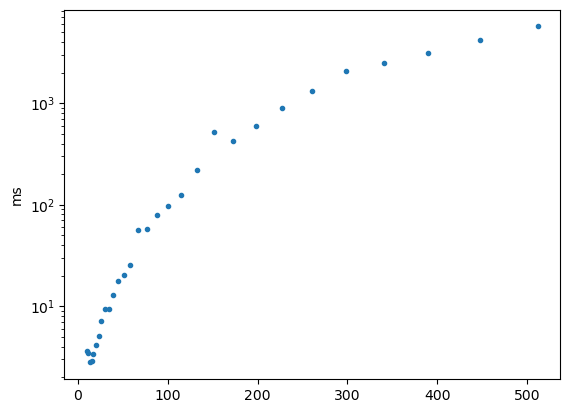

In [21]:
import matplotlib.pyplot as plt
plt.plot(seq_lengths, [a + b for a,b in timings[1024]], '.')
plt.ylabel("ms")
plt.yscale("log")

In [ ]:
first_row = query[:, :, [0, seq_length - 1], :] @ key.transpose(-1, -2) ## global attention Q_1, Q_s

In [829]:
attention(q, k, rand_idx, indices)

RuntimeError: The size of tensor a (2) must match the size of tensor b (5) at non-singleton dimension 2

In [792]:
first_row = query[:, :, [0, seq_length - 1], :] @ key.transpose(-1, -2) ## global attention Q_1, Q_s

In [793]:
rand_idx = []
for i in range(1, seq_length - 1):
    sampled = np.random.choice(np.arange(1, seq_length))
    while i - 1 <= sampled <= i + 1:
        sampled = np.random.choice(np.arange(1, seq_length))
    rand_idx.append(sampled)
positions = list(range(1, seq_length - 1))

In [806]:
rand_idx_tensor = torch.tensor(rand_idx)
rand_vals_2 = key[:, :, rand_idx_tensor, :]

In [808]:
first_keys = key[:, :, 0:1, :].expand(-1, -1, seq_length - 2, -1)

rolled = torch.stack([key[:, :, 0:1, :].expand(-1, -1, key.size(2) - 2, -1)] + [rand_vals_2] + [torch.roll(key, shifts=-i, dims=2)[:, :, 1: -1, :] for i in range(-1, 2)], dim=-2)
nice = torch.einsum("bhsd,bhskd->bhsk" , query[:, : , 1:-1, :], rolled)

In [823]:
window_keys = torch.cat([
    key[:, :, 0:seq_length-2, :],  # shifted right (-1)
    key[:, :, 1:seq_length-1, :],  # no shift (0)
    key[:, :, 2:seq_length, :]     # shifted left (+1)
], dim=-1).reshape(batch_size, n_heads, seq_length-2, 3, -1)

# 5. Combine all attention sources into one tensor for a single einsum operation
# Reshape windows and concatenate with first token and random values
combined_keys = torch.cat([
    first_keys.unsqueeze(-2),                      # first token attention
    rand_vals_2[:, :, :seq_length-2, :].unsqueeze(-2),  # random token attention
    window_keys                                    # window attention (3 positions)
], dim=-2)

attn_scores = torch.einsum("bhsd,bhskd->bhsk", query[:, : , 1:-1, :], combined_keys)


In [822]:
other_2 = torch.zeros(size=(batch_size, n_heads, seq_length, seq_length), requires_grad=False)
B, H, L, _ = other_2.shape
other_2[:, :, [0, seq_length - 1], :] = first_row

idx = torch.tensor(
    [ [0, rand_idx[i]] + indices[i].tolist() for i in range(len(positions)) ],
    device=other.device,
    dtype=torch.long
)  # shape [P, M]

idx = idx.unsqueeze(0).unsqueeze(0).expand(B, H, -1, -1)
other_2[:, :, positions, :] = other_2[:, :, positions, :].scatter(
    dim=-1,
    index=idx,       # [B,H,P,M]
    src=nice         # [B,H,P,M]
)

In [796]:
window_size = 3
base = torch.arange(0, seq_length)
indices = base.unfold(0, window_size, 1)

In [814]:
other = torch.zeros(size=(batch_size, n_heads, seq_length, seq_length), requires_grad=False)
other[:, :, [0, seq_length - 1], :] = first_row # row-wise global attention
# other[:, :, positions, 0] = global_attention.squeeze(-1) # first key global attention
# other[:, :, positions, rand_idx] = rand_result.squeeze(-1) # random attention
for pos in positions:
    other[:, :, pos, [0, rand_idx[pos - 1]] +  indices[pos - 1].tolist()] =  nice[:, :, pos - 1, :] # window attention

In [799]:
naive = torch.zeros(size=(batch_size, n_heads, seq_length, seq_length))
naive[:, :, [0, seq_length - 1]] = first_row  # Assign to the window positions
for j, i in enumerate(range(1, seq_length - 1)):
    attn_window = query[:, :, i:i+1, :] @ key[:, :, [i-1, i, i+1], :].transpose(-1, -2)
    naive[:, :, i, i-1:i+2] = attn_window.squeeze(2)  # Assign to the window positions
    
    # First token attention
    attn_first = query[:, :, i:i+1, :] @ key[:, :, 0:1, :].transpose(-1, -2)
    naive[:, :, i, 0] = attn_first.squeeze(-1).squeeze(-1)  # Assign to first position
    
    # Random attention
    attn_random = query[:, :, i:i+1, :] @ key[:, :, rand_idx[j]:rand_idx[j]+1, :].transpose(-1, -2)
    naive[:, :, i, rand_idx[j]] = attn_random.squeeze(-1).squeeze(-1)  # Assign to random position

In [800]:
print(torch.allclose(other[:, :, [0, seq_length - 1]], 
                     naive[:, :, [0, seq_length - 1]])) ## first and alst query

print(torch.allclose(other[:, :, positions, 0], 
               naive[:, :,  positions, 0])) # first column attention

print(torch.allclose(other[:, :, positions, rand_idx], 
               naive[:, :, positions, rand_idx])) # random vals

for i in positions:
    print(torch.allclose(other[:, :, i, indices[i - 1]], 
               naive[:, :, i, indices[i - 1]])) 

True
True
True
True
True
True
True
True
True
True
True


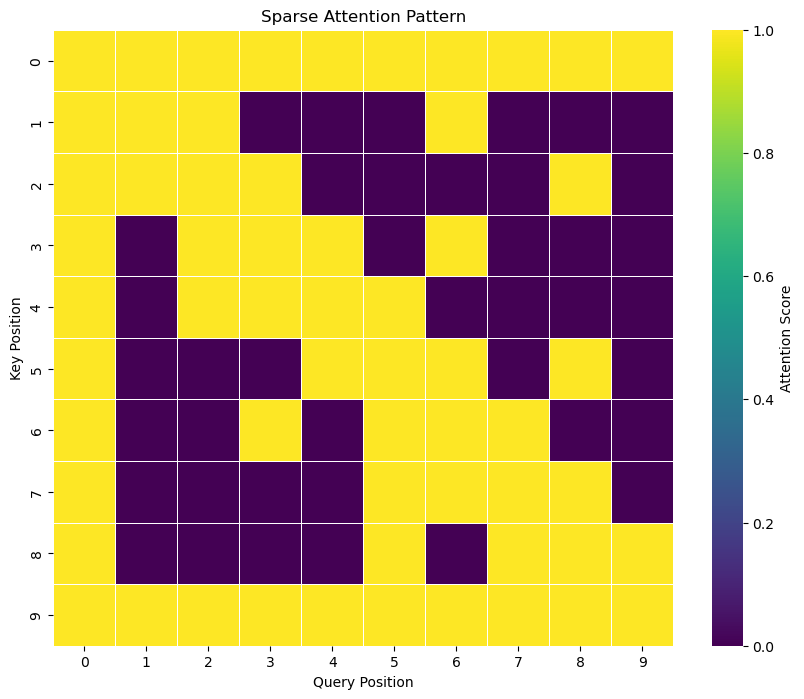

In [801]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(naive[0, 0, ...].detach().numpy() != 0,    cmap='viridis',
    linewidths=0.5,  # Width of grid lines
    linecolor='white',  # Color of grid lines
    cbar_kws={'label': 'Attention Score'})
plt.title('Sparse Attention Pattern')
plt.xlabel('Query Position')
plt.ylabel('Key Position')
plt.show()

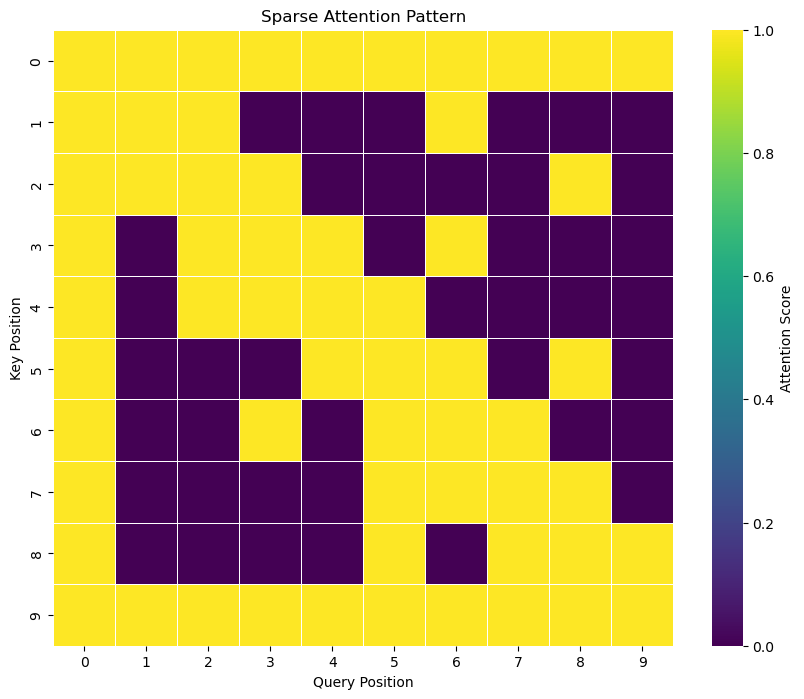

In [802]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(other[0, 0, ...].detach().numpy() != 0,    cmap='viridis',
    linewidths=0.5,  # Width of grid lines
    linecolor='white',  # Color of grid lines
    cbar_kws={'label': 'Attention Score'})
plt.title('Sparse Attention Pattern')
plt.xlabel('Query Position')
plt.ylabel('Key Position')
plt.show()

tensor([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]])